In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams["figure.figsize"] = (20,8)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pandas import DataFrame
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import os
import random

import plotly
from chart_studio import plotly as py
import plotly.graph_objs as go
import chart_studio
chart_studio.tools.set_credentials_file(username='mohita24',api_key='Gl9VXrB19507Nlicdlwe')
# Authenticate with your account
#plotly.tools.set_credentials_file(username='mohita24',                                              
#                                  api_key='Gl9VXrB19507Nlicdlwe')
# Offline mode
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [237]:
df=pd.read_csv("CADCurve dep.csv")
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df["Date"]]
df=df.iloc[:,1:]
df.index=x
df.head()

1M       2M        3M       6M        9M        1Y  \
1995-07-14  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-15  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-16  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-17  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   
1995-07-18  0.065547  0.06447  0.063373  0.06397  0.064241  0.064587   

                  2Y        3Y        4Y        5Y        6Y        7Y  \
1995-07-14  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-15  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-16  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-17  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   
1995-07-18  0.067764  0.069852  0.072227  0.074802  0.076541  0.078377   

                  8Y        9Y       10Y  
1995-07-14  0.079875  0.081453  0.083113  
1995-07-15  0.079875  0.081453  0.083113  
1995-07-16  0.079875  0.081453  0.083113  
1995-07-17  0.079875  0.081453  0.083113  
1995-07-18  0.079875  0.081453  0.083113

## Multivariate time series forecasting for Multi-step using stacked LSTM sequence to sequence Autoencoder

In [248]:
def series_to_supervised(ts, lag, steps_ahead):
    X, y = [],[]
    for i in range(len(ts)):
        past_end = i + lag
        future_end = past_end + steps_ahead
        if future_end > len(ts):
            break
        past, future = ts[i:past_end, :], ts[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

def model1(lag, steps_ahead, n_features):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    tf.random.set_seed(seed=42)
    np.random.RandomState(42)
    random.seed(42)
    
    
    #encoder part converts the given input sequence to a fixed-length vector,
    #which acts as a summary of the input sequence. The fixed length vector is also called context vector.
    encoder_inputs = tf.keras.layers.Input(shape=(lag, n_features))
    encoder_l1 = tf.keras.layers.LSTM(150, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]

    #decoder receives the context vector
    decoder_inputs = tf.keras.layers.RepeatVector(steps_ahead)(encoder_outputs1[0])
    decoder_l1 = tf.keras.layers.LSTM(150, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    model_1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_1.summary()
    print(encoder_l1.input_shape)
    print(encoder_l1.output_shape)
    print(np.asarray(encoder_outputs1[1:]).shape)
    return model_1

def model2(lag, steps_ahead, n_features):
    os.environ['PYTHONHASHSEED'] = '42'
    np.random.seed(42)
    tf.random.set_seed(seed=42)
    np.random.RandomState(42)
    random.seed(42)
    
    encoder_inputs = tf.keras.layers.Input(shape=(lag, n_features))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs = tf.keras.layers.RepeatVector(steps_ahead)(encoder_outputs2[0])

    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

    model_2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    model_2.summary()
    return model_2

In [239]:
# function for training
def training(lag,steps_ahead,n_features,model,path,train,val):
    X_train, y_train = series_to_supervised(train.values,lag, steps_ahead)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
    print(X_train.shape)
    print(y_train.shape)
    X_val, y_val = series_to_supervised(val.values,lag, steps_ahead)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1],n_features))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], n_features))
    print(X_val.shape)
    print(y_val.shape)
    
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    checkpoint1 = tf.keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_loss',
                                                     save_best_only=True,
                                                     mode='min')
    es=tf.keras.callbacks.EarlyStopping(patience=5)


    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    history=model.fit(X_train,y_train,epochs=25,validation_data=(X_val,y_val),batch_size=32,callbacks=[reduce_lr,checkpoint1,es])
    
    plt.figure()
    plt.plot(np.arange(len(history.history['loss'])), history.history['loss'],
             color='r', label='Training loss')

    plt.plot(np.arange(len(history.history['loss'])),history.history['val_loss'],
             color='b', label='Validation loss')
    plt.title('Training vs Validation Loss (MAE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    
    
def testing(Xtest,X_input,path,model):
    
    model.load_weights(path)
    output=model.predict(X_input)
    output=output.reshape(output.shape[1],output.shape[2])
    c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
    c2=['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y',
       '8Y', '9Y', '10Y']
    output = pd.DataFrame(output)
    output.columns=c1
    Xtest= pd.DataFrame(Xtest)
    Xtest.columns=c2
    for i,j in zip(c1,c2):
        combine = pd.concat([output[i], Xtest[j]], axis=1)
        combine['MAPE'] = combine.apply(lambda row: abs(row[i]-row[j])/row[j] *100, axis = 1)
        combine['MAPE'] = pd.Series(["{}%".format(val) for val in combine['MAPE']],index = combine.index)
        combine = combine.reset_index()
        print(combine)
    return output, Xtest

 
def plot_errors(Xtest,X_input,path,model):
    
    model.load_weights(path)
    output=model.predict(X_input)
    output=output.reshape(output.shape[1],output.shape[2])
    c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
    c2=['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y',
       '8Y', '9Y', '10Y']
    output = pd.DataFrame(output)
    output.columns=c1
    Xtest= pd.DataFrame(Xtest)
    Xtest.columns=c2
    for i,j in zip(c1,c2):
        combine = pd.concat([output[i], Xtest[j]], axis=1)
        combine['MAPE'] = combine.apply(lambda row: abs(row[i]-row[j])/row[j] *100, axis = 1)
        combine['MAPE'] = pd.Series(["{}%".format(val) for val in combine['MAPE']],index = combine.index)
        combine = combine.reset_index()
        #print(combine)
        plt.plot(combine["MAPE"],label="MAPE plot for"+str(i))
        plt.legend()
        plt.show()
    
    
    
def errors(Xtest,X_input,path,model,output):
    c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
    c2=['1M', '2M', '3M', '6M', '9M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y',
       '8Y', '9Y', '10Y']
    Xtest= pd.DataFrame(Xtest)
    Xtest.columns=c2
    for k,j in zip(c1,c2):
        combine = pd.concat([output[k], Xtest[j]], axis=1)
        combine['MAPE'] = combine.apply(lambda row: row[k] /row[j] *100, axis = 1)
        combine['MAPE'] = pd.Series(["{0:.2f}%".format(val) for val in combine['MAPE']],index = combine.index)
        #combine = combine.reset_index()
        print(k,j)
        forecast_errors = [combine[j][i]- combine[k][i] for i in range(len(combine[j]))]
        bias = sum(forecast_errors) * 1.0/len(combine[j])
        print('Bias: %f' % bias)
        #print('R2 score:', r2_score(combine[j].values, combine[k].values))
        print('Mean absolute error:', mean_absolute_error(combine[j].values, combine[k].values))
        print('Mean squared error:', mean_squared_error(combine[j].values, combine[k].values))
        print('Root mean squared error:', np.sqrt(mean_squared_error(combine[j].values, combine[k].values)))


       
        
def plot_SwapCurves(output,X_test):
    for i in range(steps_ahead):
        plt.plot(output.iloc[i:i+1,].values[0],label="forecasted Swap curve for"+ str(i+1)+"th step ahead" )
        plt.plot(X_test.iloc[i:i+1,].values[0],label="Actual Swap curve for"+ str(i+1)+"th step ahead")
        plt.legend()
        plt.show()
        


Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
lstm_86 (LSTM)                  [(None, 150), (None, 99600       input_38[0][0]                   
__________________________________________________________________________________________________
repeat_vector_37 (RepeatVector) (None, 19, 150)      0           lstm_86[0][0]                    
__________________________________________________________________________________________________
lstm_87 (LSTM)                  (None, 19, 150)      180600      repeat_vector_37[0][0]           
                                                                 lstm_86[0][1]             

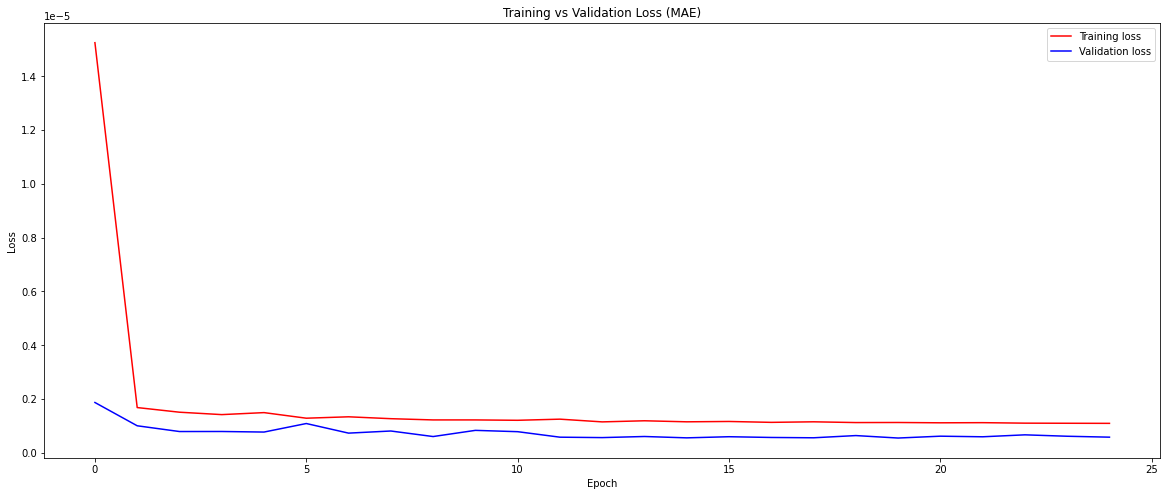

In [240]:
lag = 30
steps_ahead = 19
n_features = 15

train,val = df[1:7700], df[7700:-steps_ahead]

path1="best_weights1.hdf5"

model1=model1(lag, steps_ahead, n_features)

training(lag,steps_ahead,n_features,model1,path1,train,val)

## MAPE for different steps ahead

In [241]:
Xtest= df[-steps_ahead:].values
X_input=df[-(lag+steps_ahead):-steps_ahead].values
X_input=X_input.reshape(1,lag,n_features)
output,X_test=testing(Xtest,X_input,path1,model1)

    index   1M_pred        1M                 MAPE
0       0  0.004098  0.004175  1.8548959921933907%
1       1  0.004015  0.004175   3.825976088375386%
2       2  0.003984  0.004175   4.576811694099516%
3       3  0.003981  0.004175    4.65257785277452%
4       4  0.003990  0.004175   4.434168767072481%
5       5  0.004002  0.004175   4.147444103292361%
6       6  0.004012  0.004175  3.9045083308648185%
7       7  0.004019  0.004175   3.744320848030956%
8       8  0.004022  0.004175   3.666335130166148%
9       9  0.004023  0.004175  3.6525047110940143%
10     10  0.004021  0.004175   3.680221317057122%
11     11  0.004019  0.004175  3.7299773650255004%
12     12  0.004017  0.004175  3.7873959113023927%
13     13  0.004015  0.004175  3.8437883297126425%
14     14  0.004012  0.004175   3.895083569480985%
15     15  0.004010  0.004200   4.512228178126466%
16     16  0.004009  0.004200   4.552541140999107%
17     17  0.004007  0.004200  4.5903151411385705%
18     18  0.004006  0.004200  

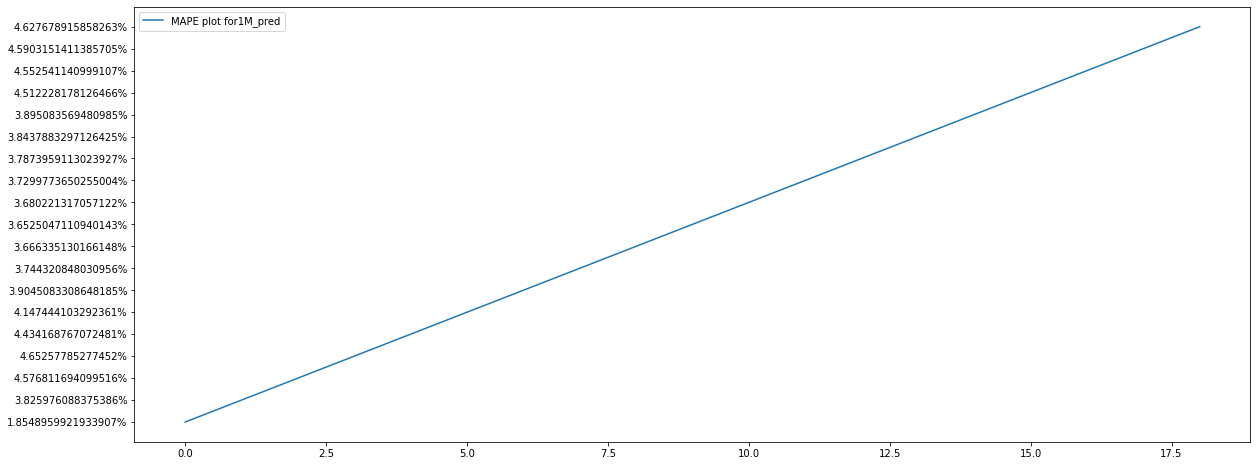

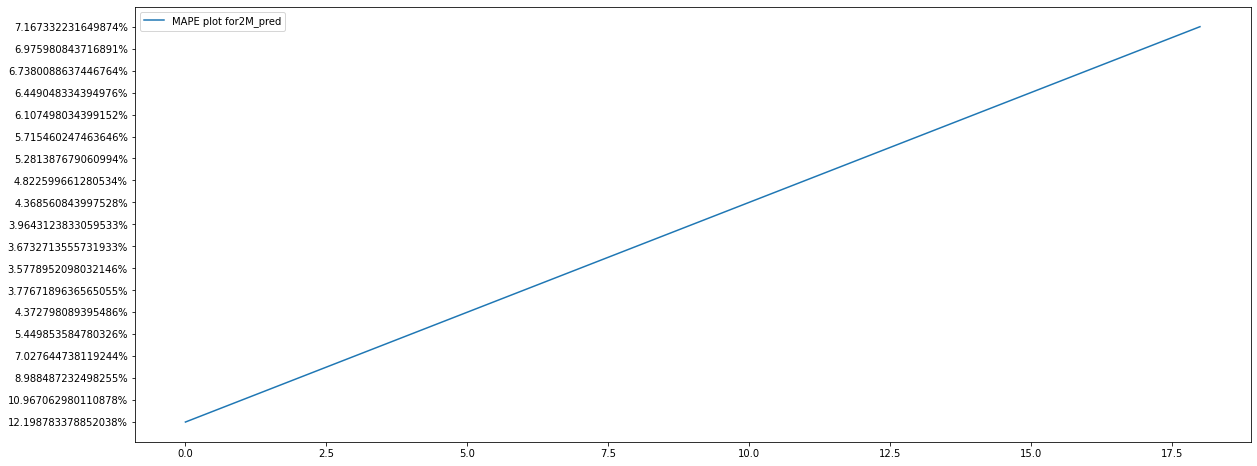

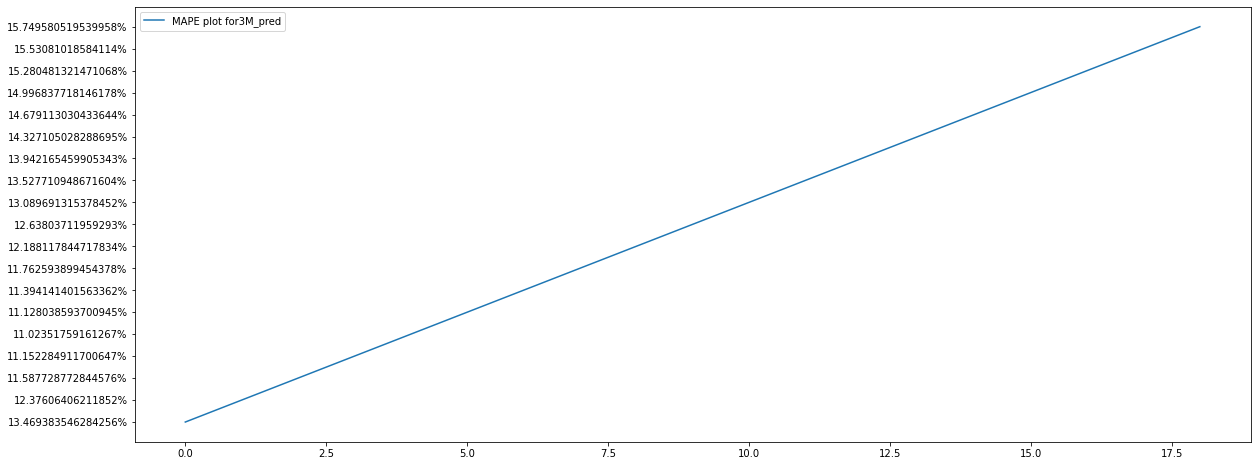

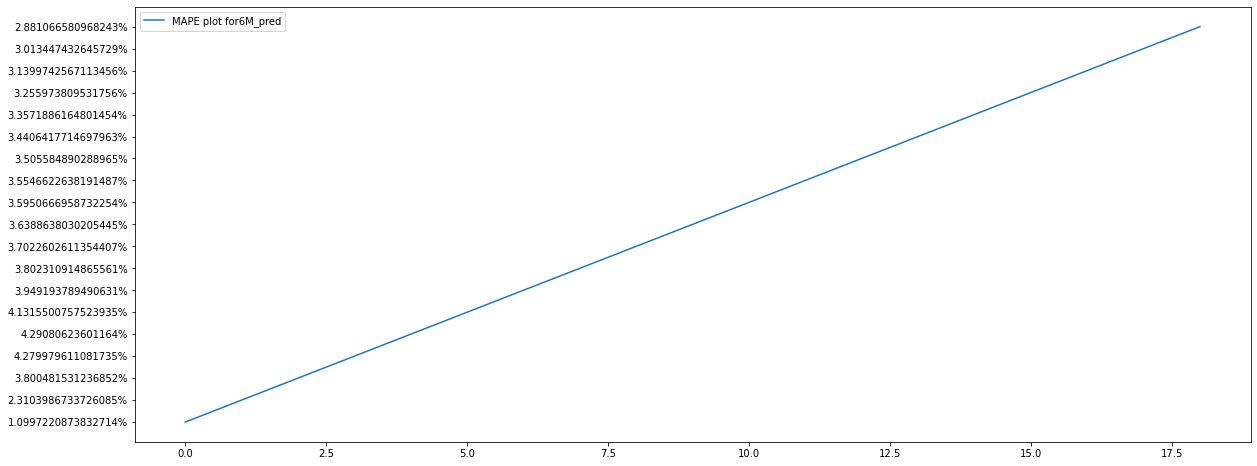

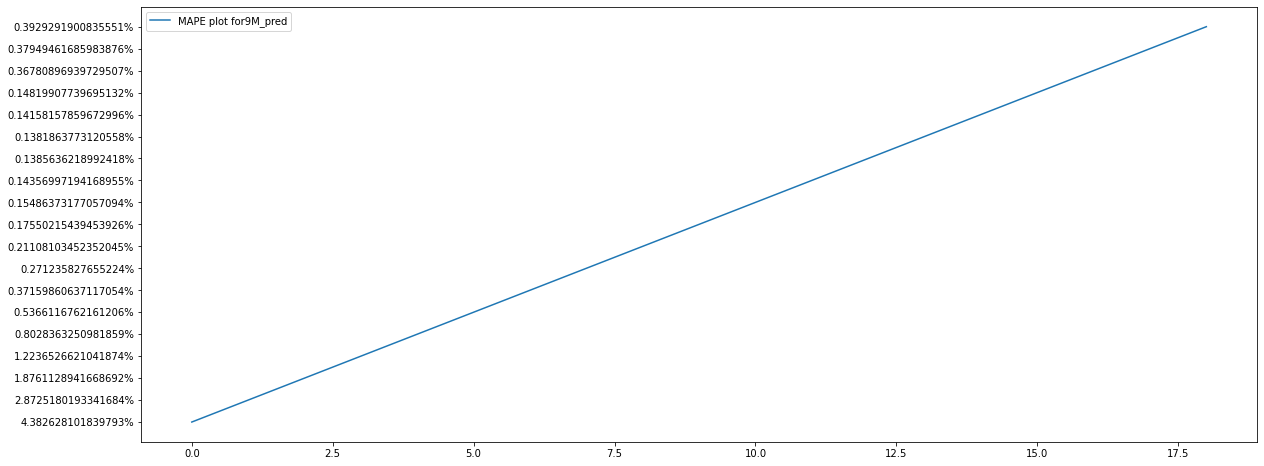

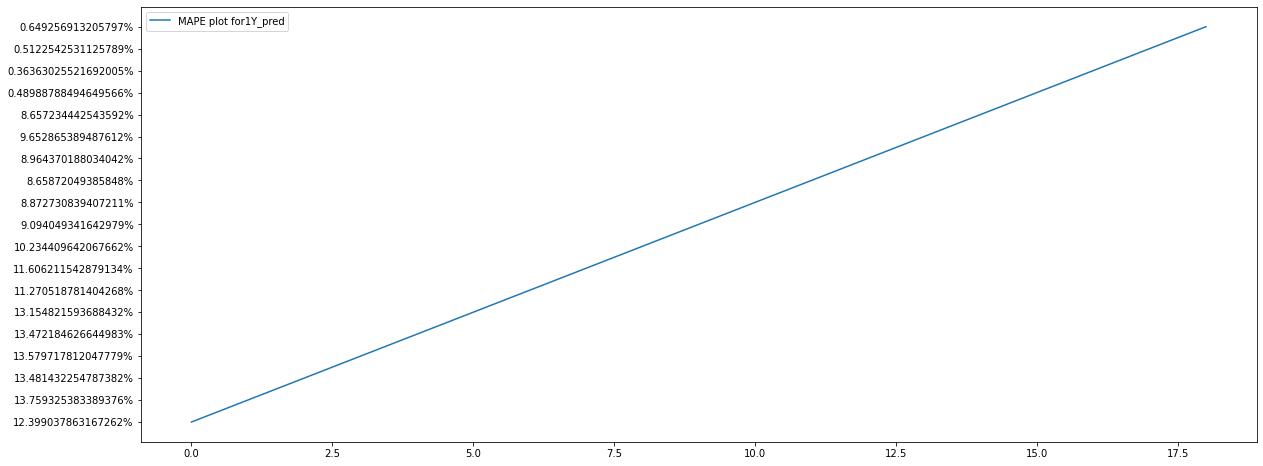

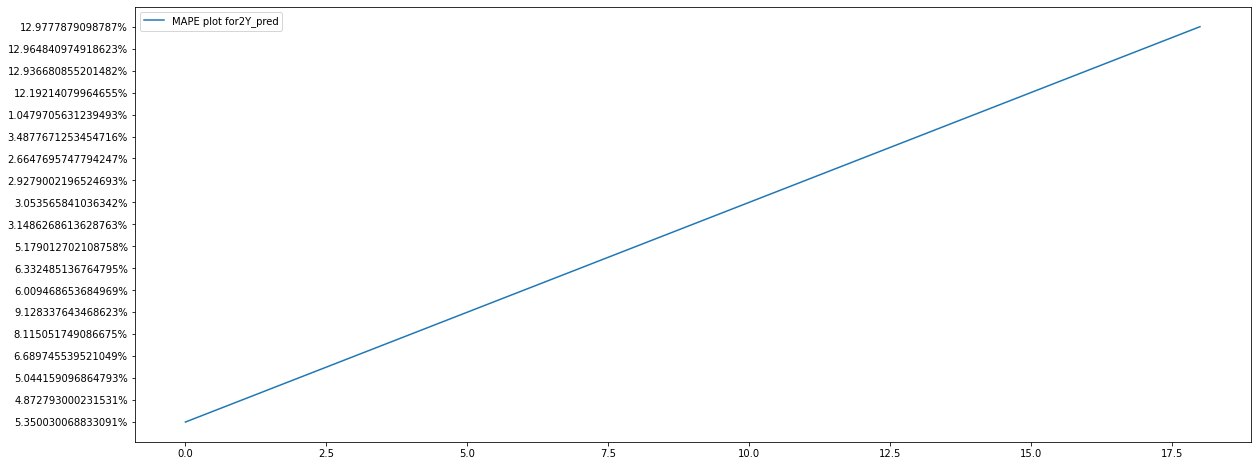

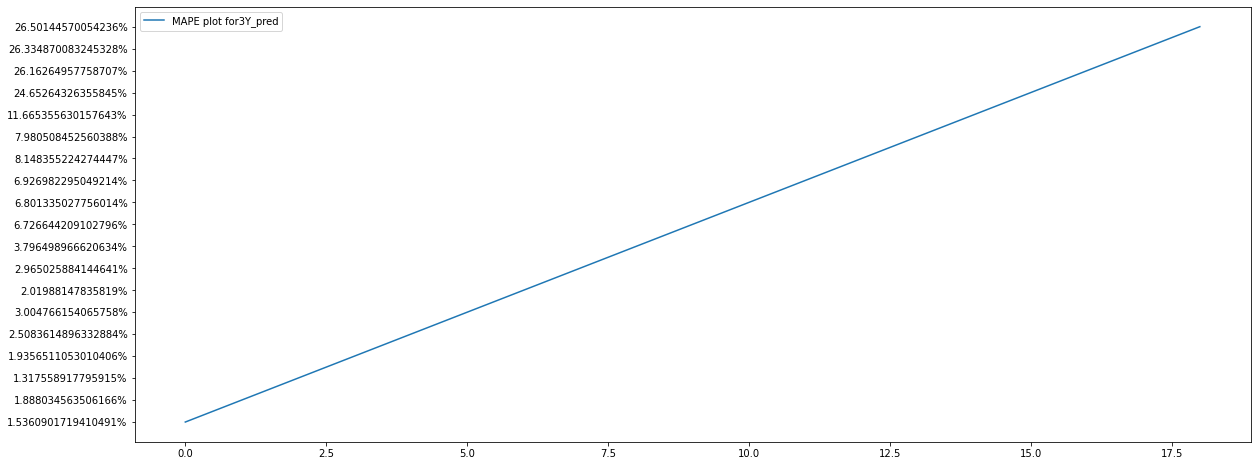

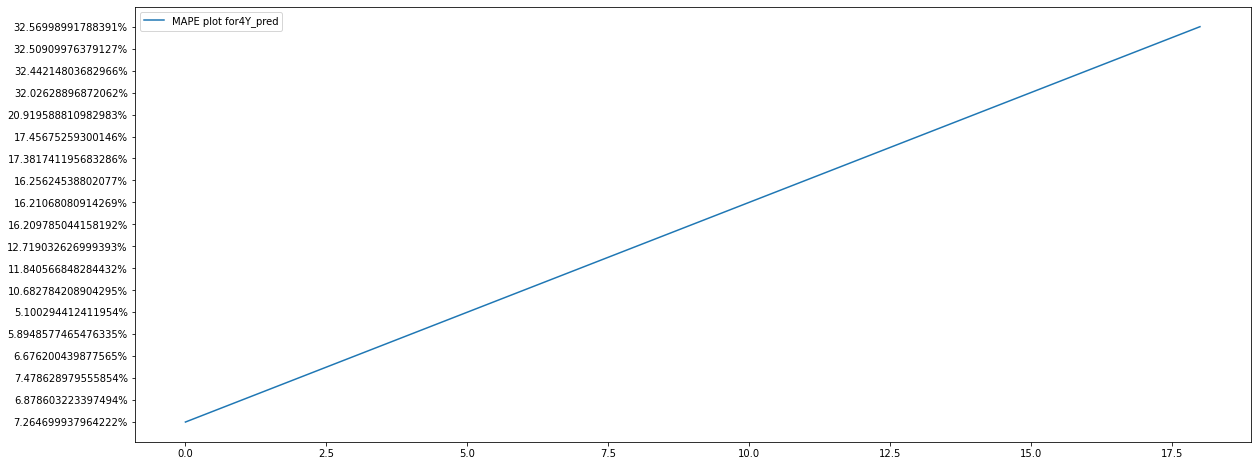

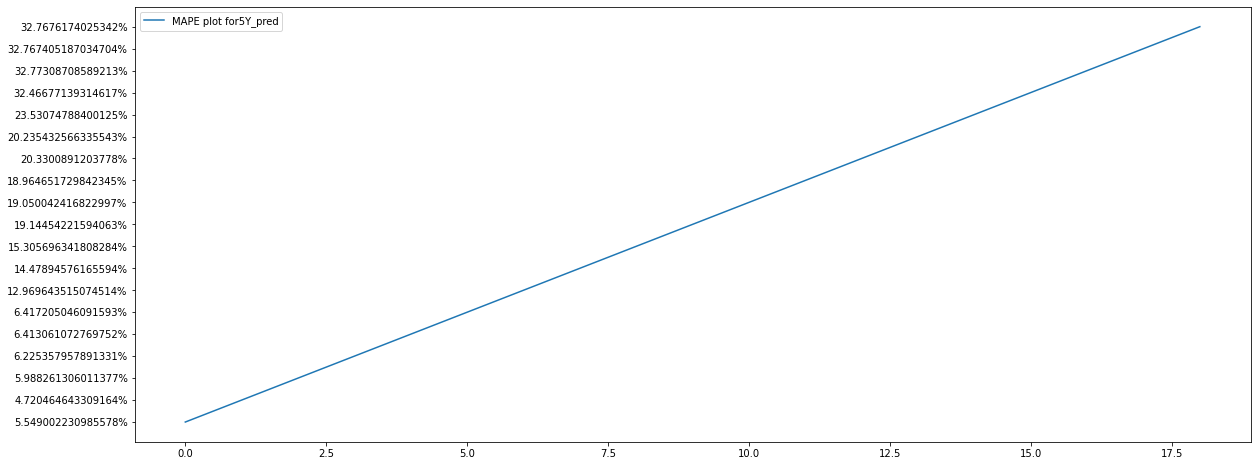

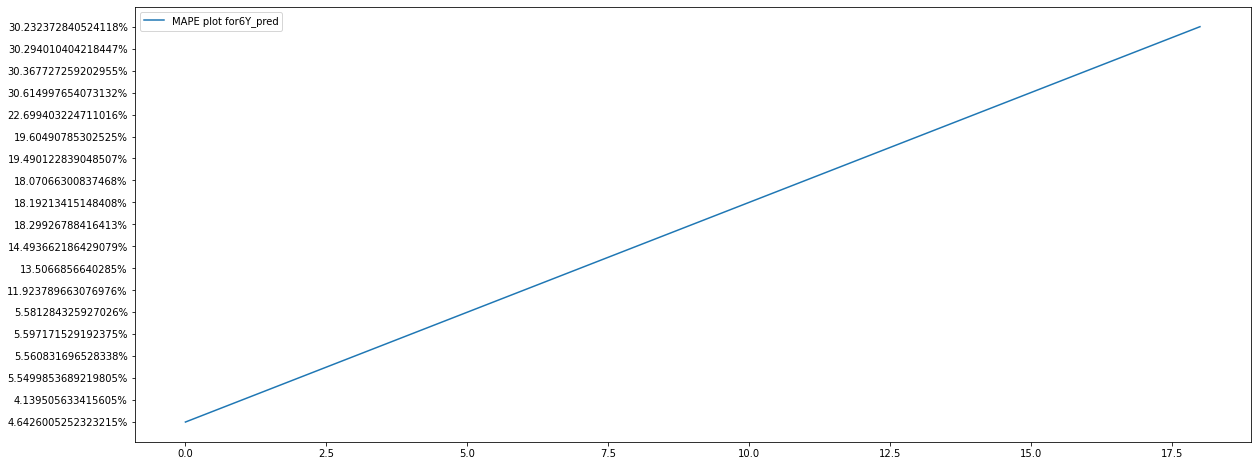

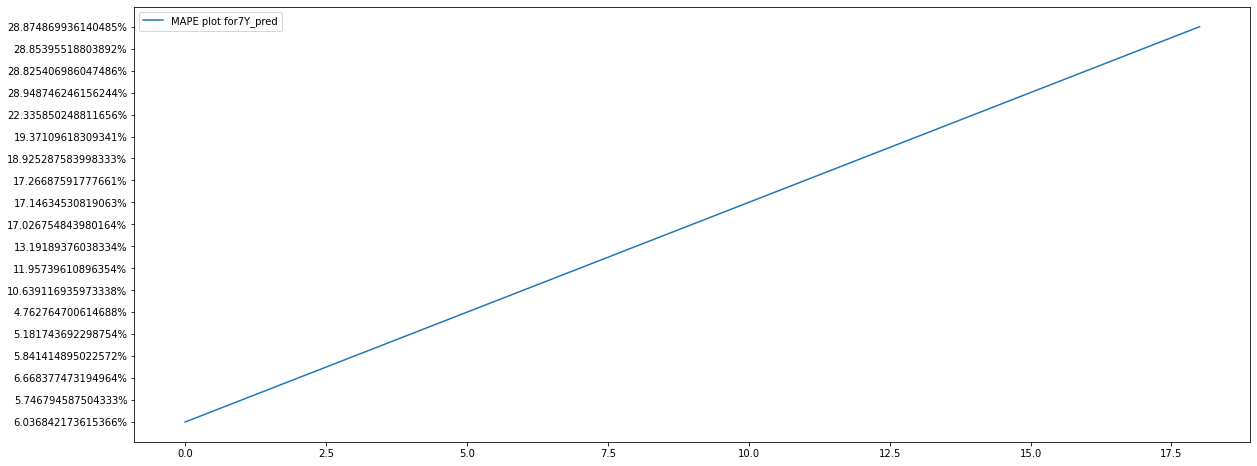

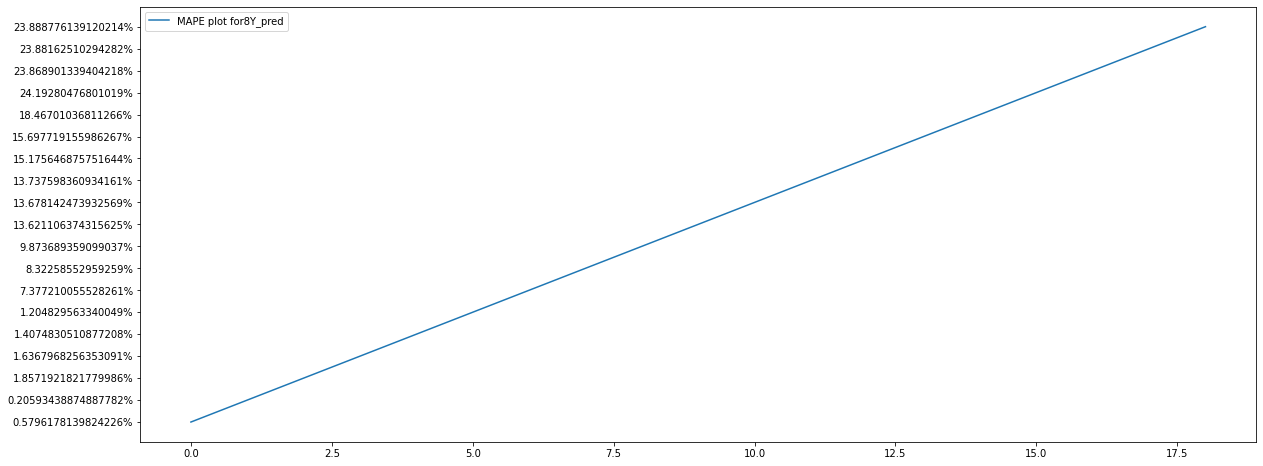

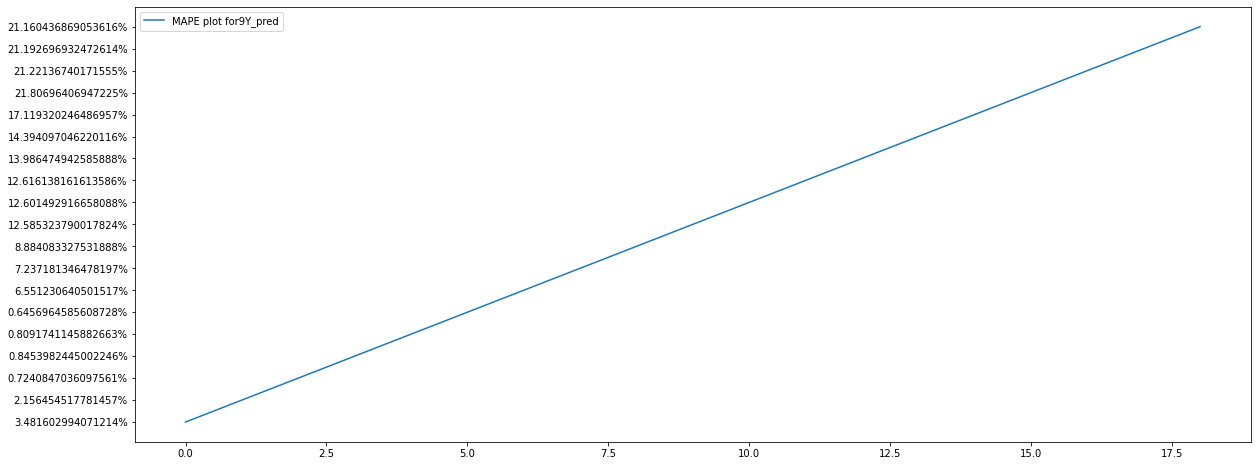

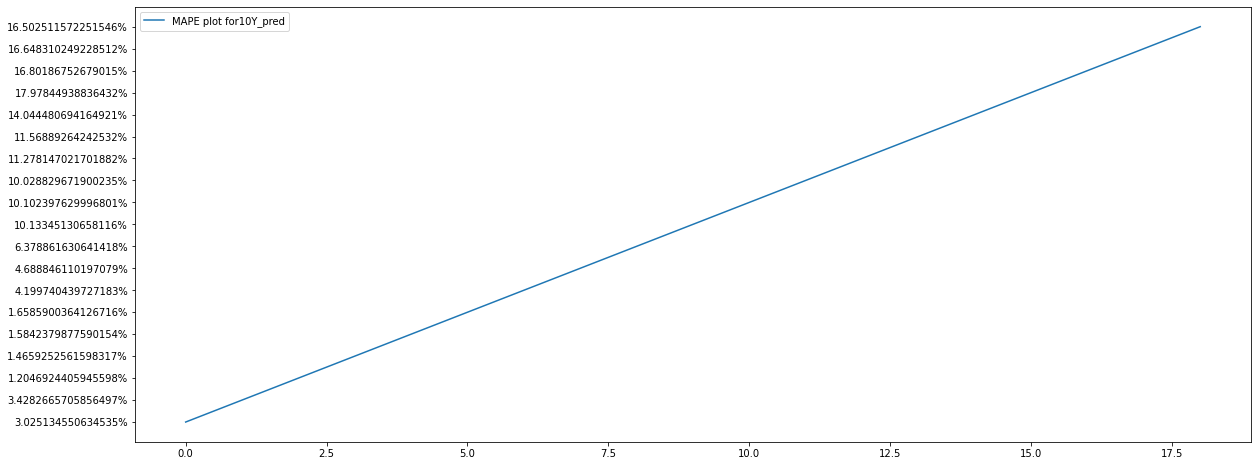

In [242]:
plot_errors(Xtest,X_input,path1,model1)

In [243]:
errors(X_test,X_input,path1,model1,output)

1M_pred 1M
Bias: 0.000167
Mean absolute error: 0.0001665347094598568
Mean squared error: 2.84309185729414e-08
Root mean squared error: 0.00016861470449798085
2M_pred 2M
Bias: -0.000265
Mean absolute error: 0.0002646510854755576
Mean squared error: 7.998877429471943e-08
Root mean squared error: 0.0002828228673476023
3M_pred 3M
Bias: -0.000575
Mean absolute error: 0.0005752973101640998
Mean squared error: 3.356827896413216e-07
Root mean squared error: 0.0005793813853079175
6M_pred 6M
Bias: 0.000184
Mean absolute error: 0.00019083966867704136
Mean squared error: 3.805979987668038e-08
Root mean squared error: 0.00019508921004678957
9M_pred 9M
Bias: 0.000046
Mean absolute error: 4.5938645499317036e-05
Mean squared error: 6.329331101285855e-09
Root mean squared error: 7.955709334362245e-05
1Y_pred 1Y
Bias: -0.000397
Mean absolute error: 0.0004079121307255845
Mean squared error: 2.110872296364958e-07
Root mean squared error: 0.0004594423028373593
2Y_pred 2Y
Bias: -0.000029
Mean absolute error

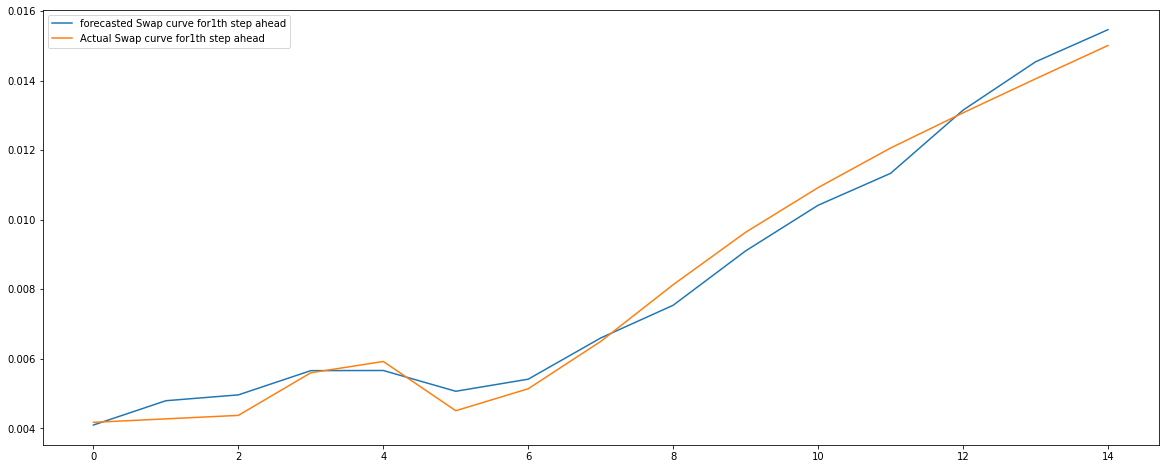

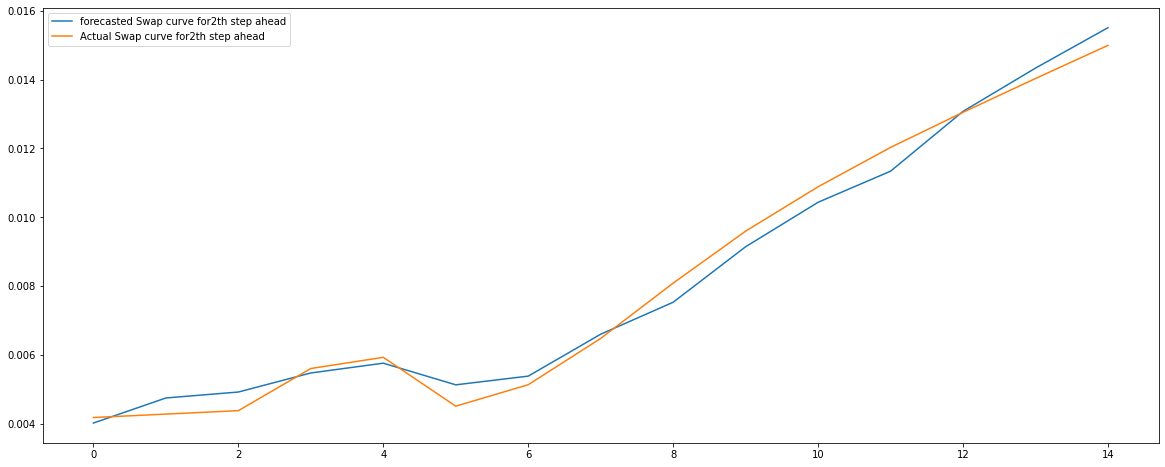

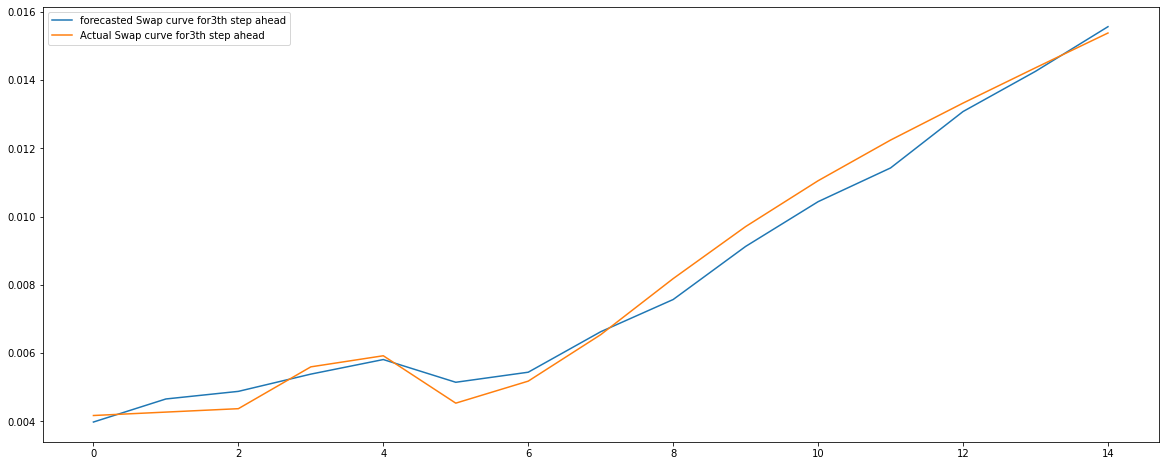

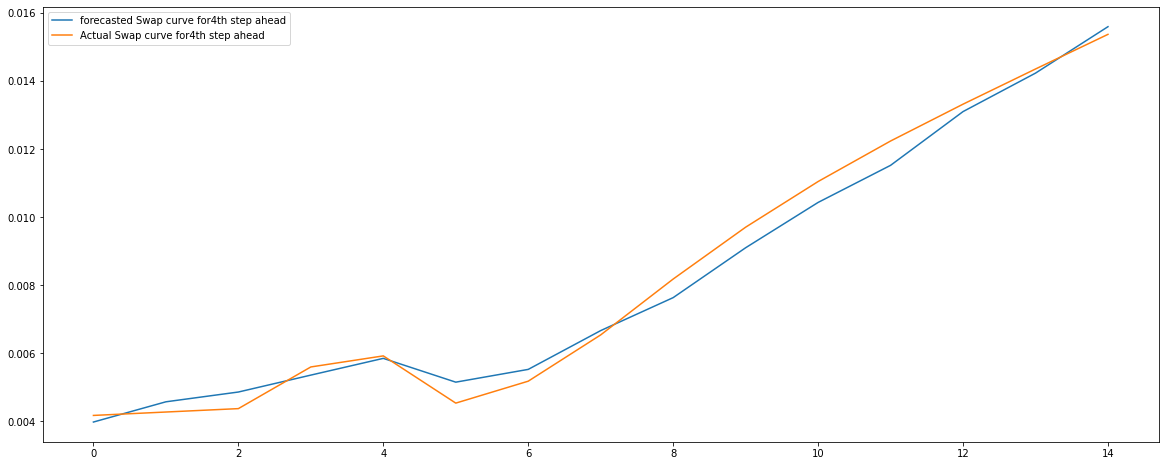

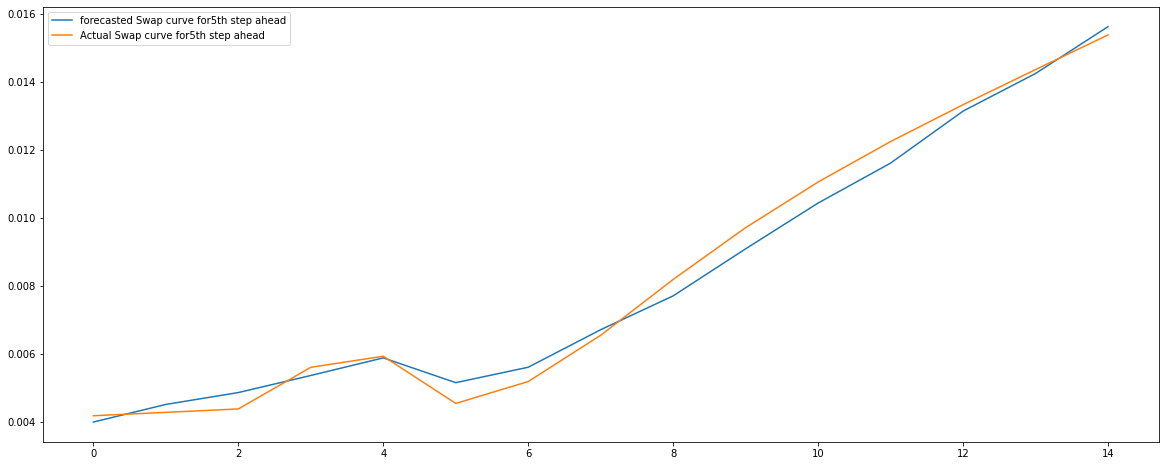

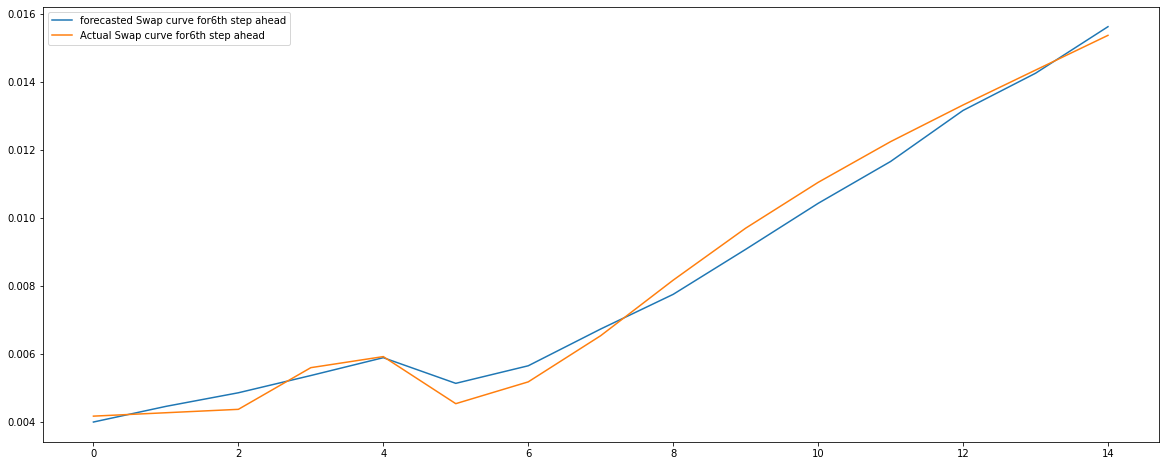

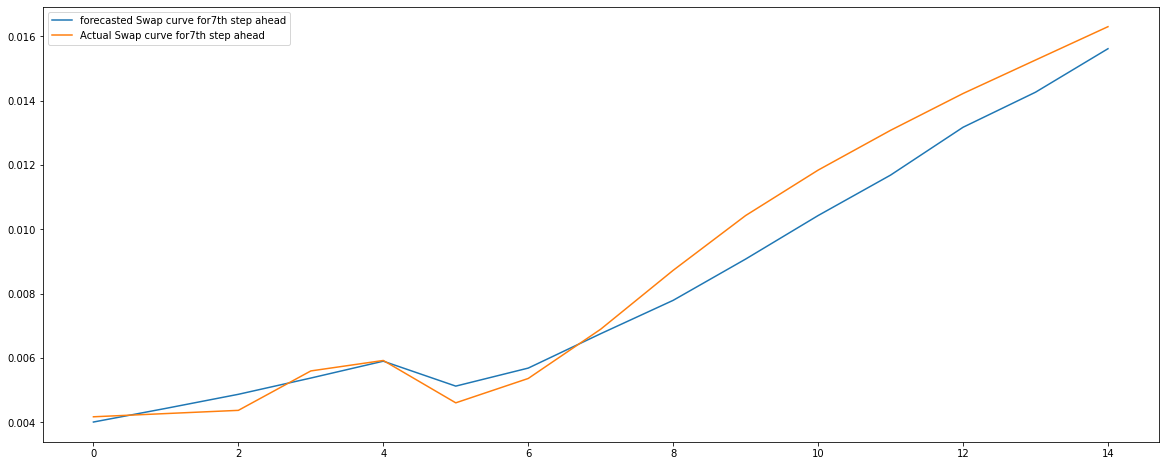

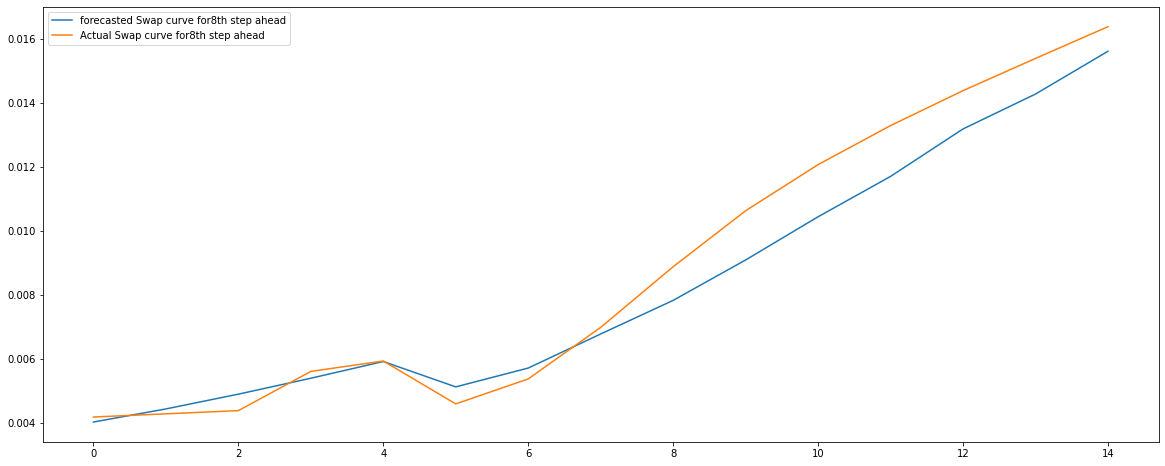

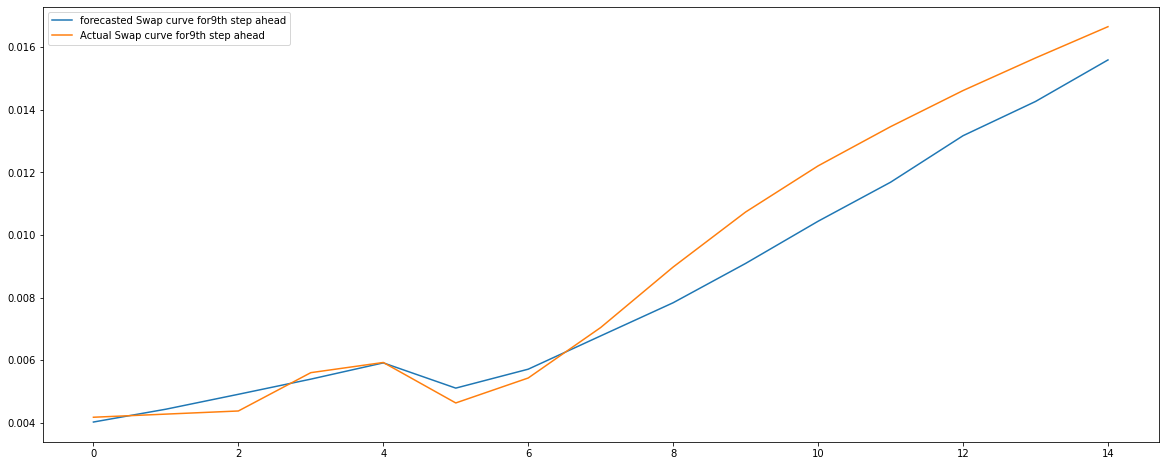

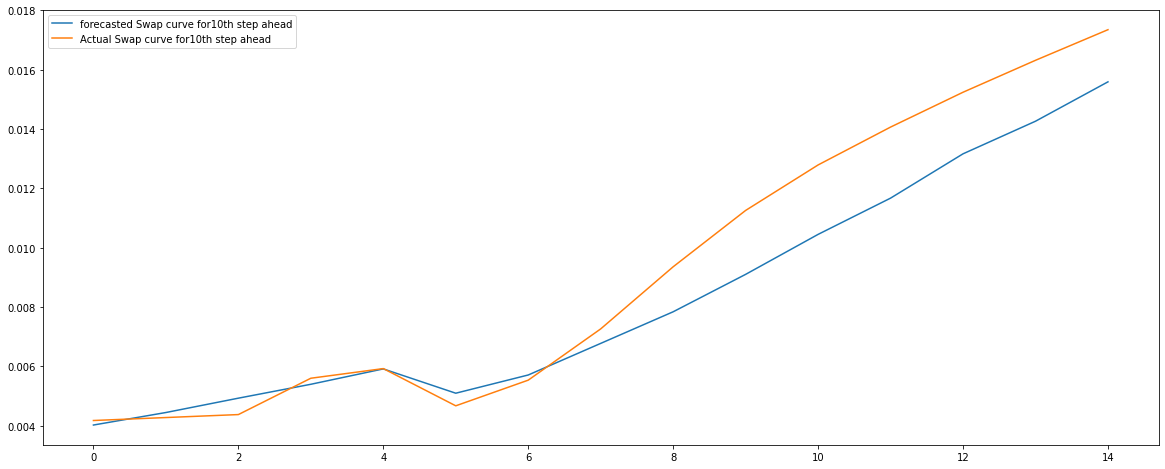

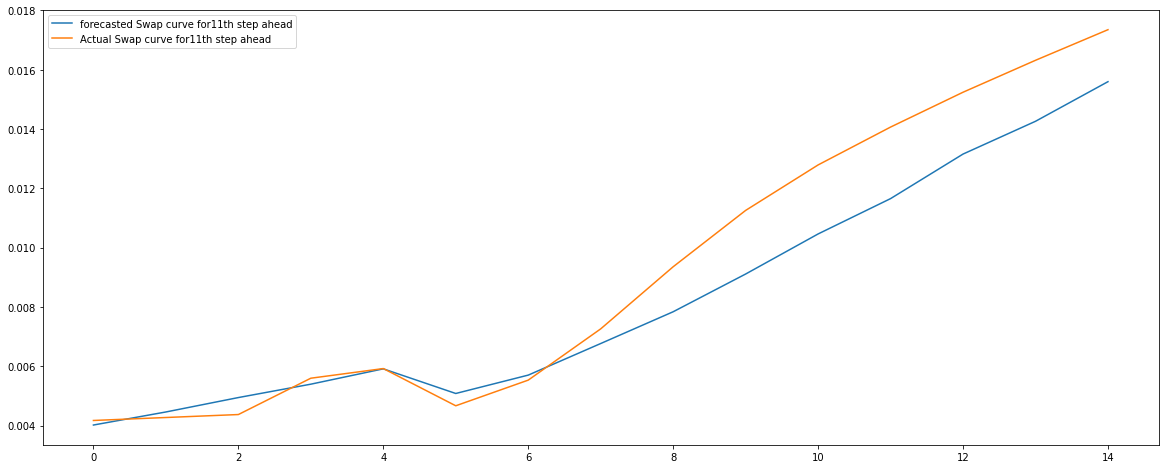

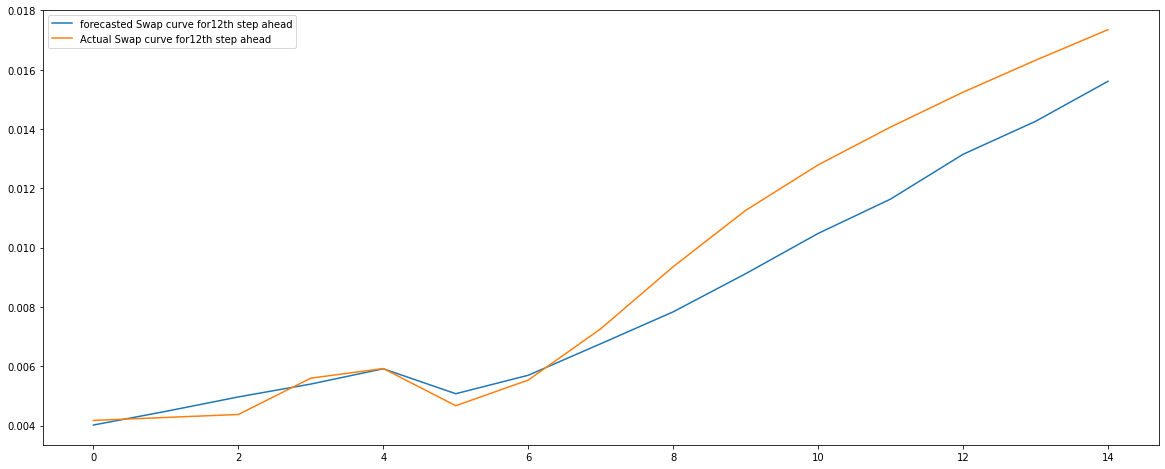

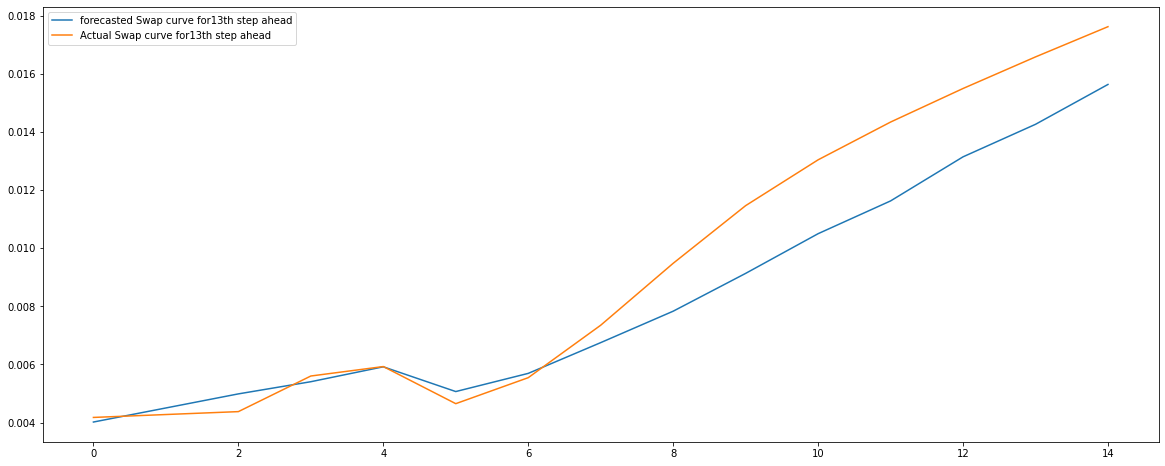

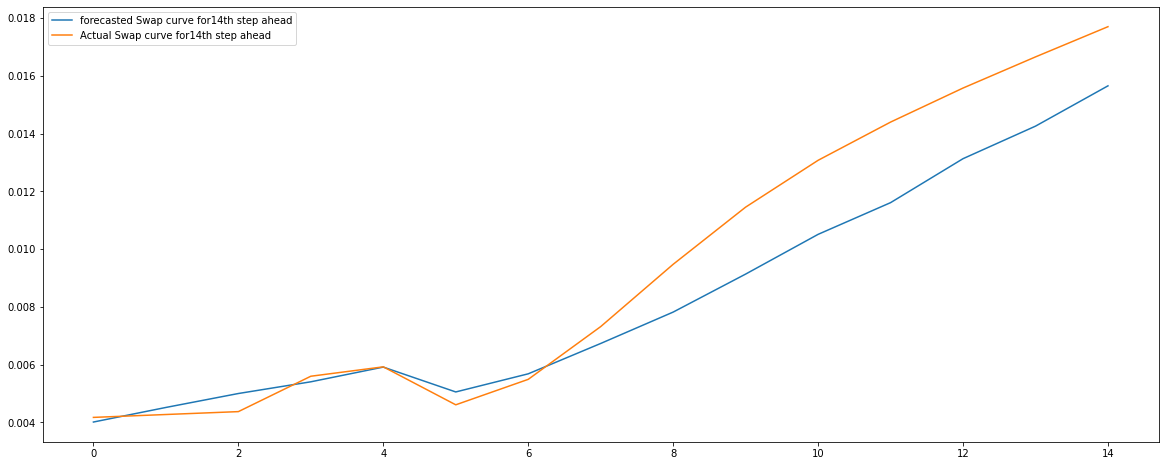

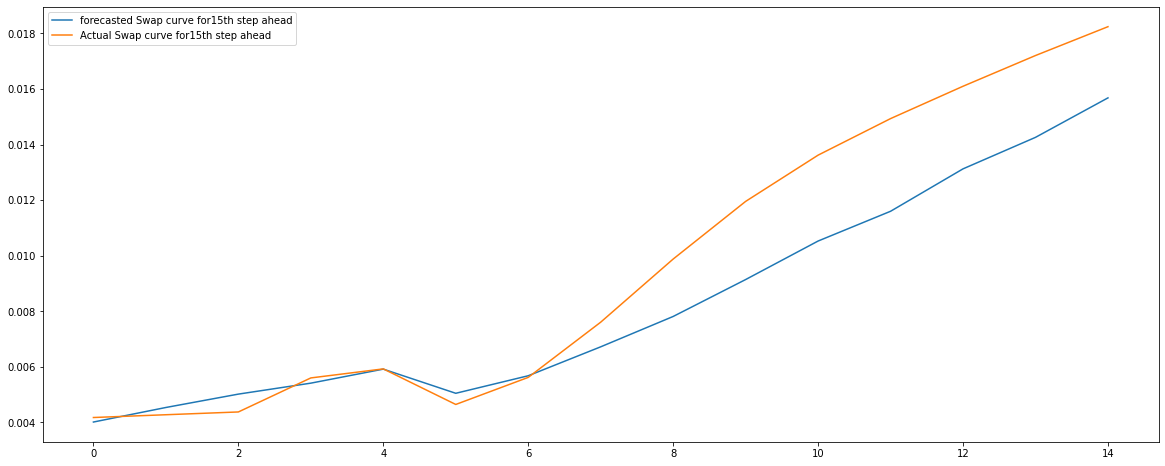

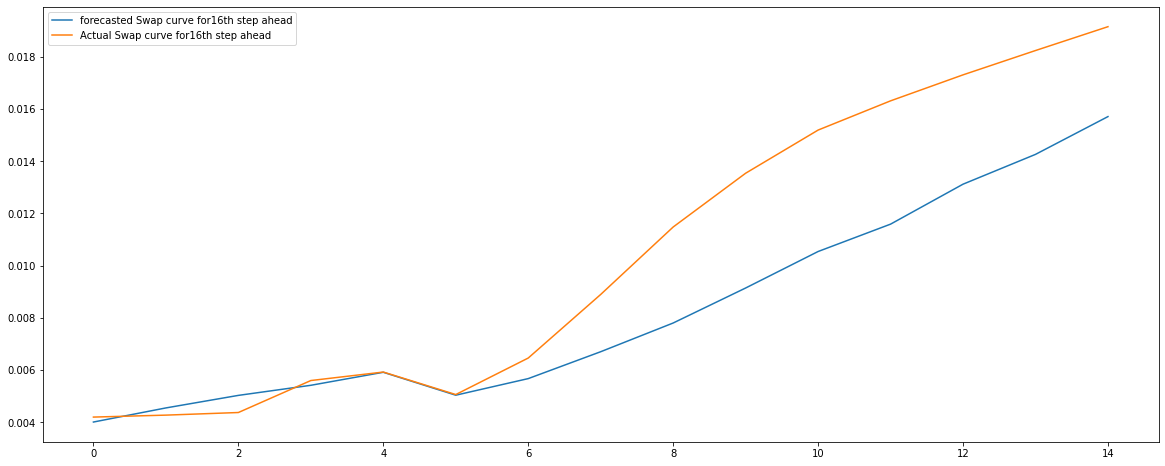

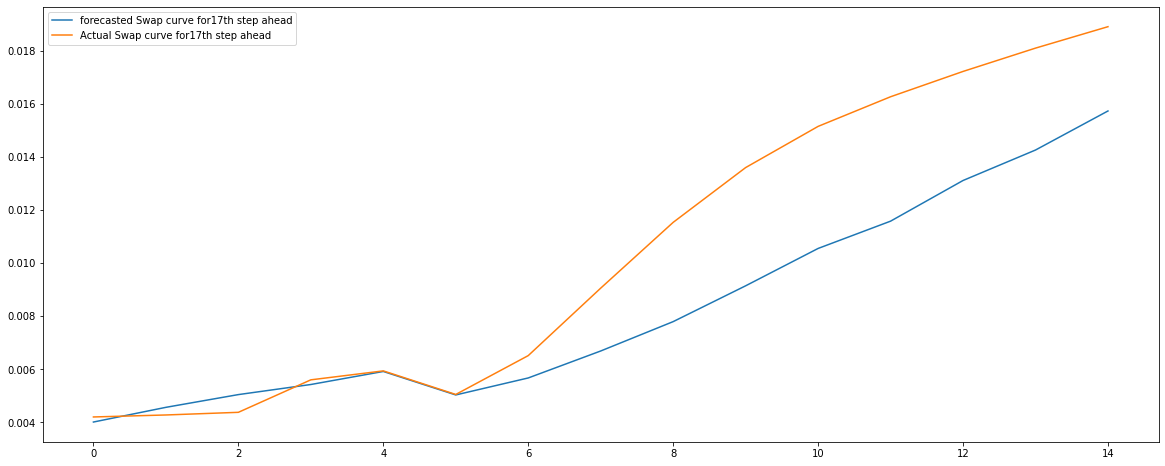

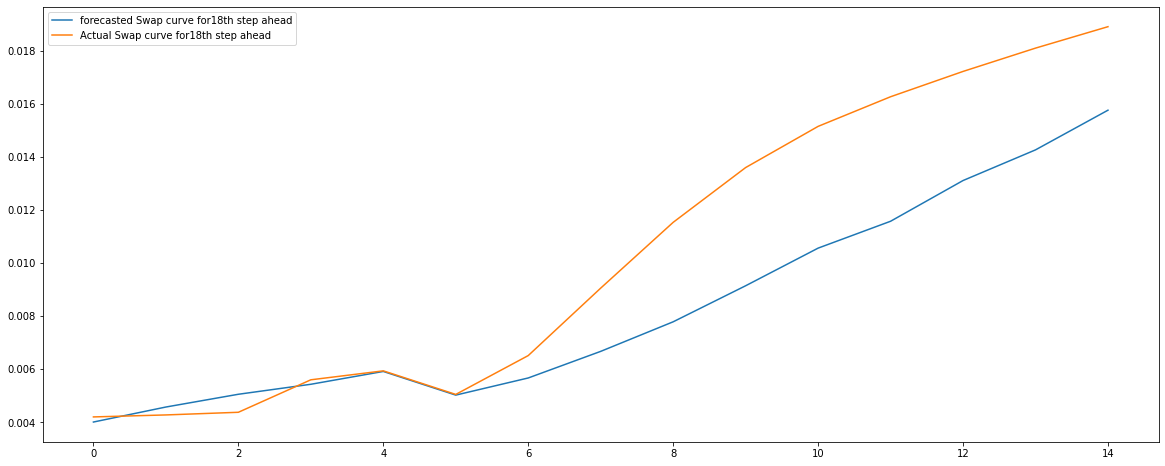

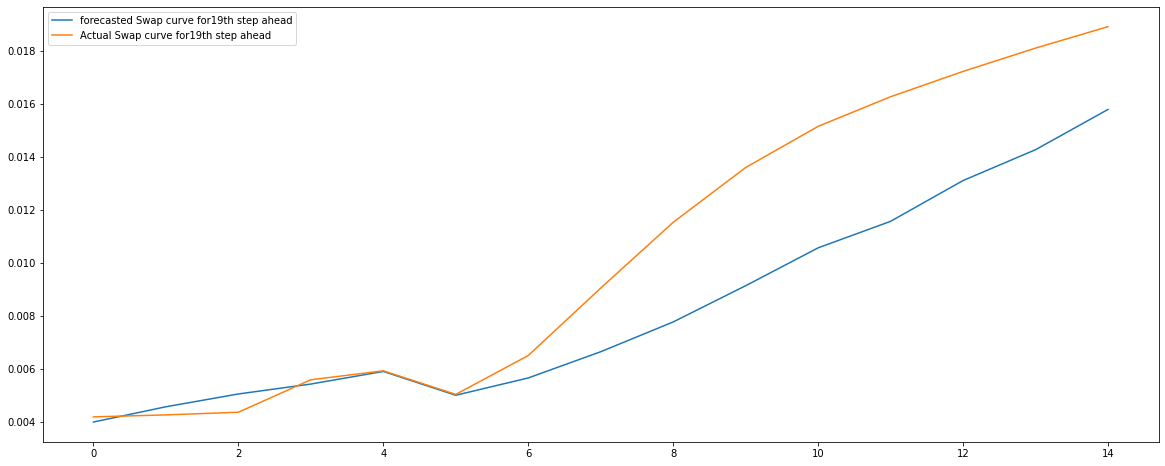

In [208]:
plot_SwapCurves(output,X_test)

## Mean Absolute Error with increasing time steps

In [245]:
mae=[]
for i in range(steps_ahead):
    mae.append(mean_absolute_error(output.iloc[i],X_test.iloc[i]))  
ser = go.Scatter(x=np.arange(1,steps_ahead+1),
                         y=mae)
layout = go.Layout(title='Mean Absolute Error with increasing steps', xaxis=dict(title='Steps'),
                   yaxis=dict(title='MAE'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

## Mean Squared Error with increasing maturity

In [246]:
mae_maturity=[]
for i in range(n_features):
    mae_maturity.append(mean_absolute_error(output.iloc[:,i:i+1],X_test.iloc[:,i:i+1])) 
ser = go.Scatter(x=output.columns,
                         y=mae)
layout = go.Layout(title='Mean Absolute Error with increasing maturity', xaxis=dict(title='Maturity'),
                   yaxis=dict(title='MAE'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

## Forecasting the final Swap Curve for 19th March 2021 using the entire data.

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
lstm_88 (LSTM)                  [(None, 150), (None, 99600       input_39[0][0]                   
__________________________________________________________________________________________________
repeat_vector_38 (RepeatVector) (None, 19, 150)      0           lstm_88[0][0]                    
__________________________________________________________________________________________________
lstm_89 (LSTM)                  (None, 19, 150)      180600      repeat_vector_38[0][0]           
                                                                 lstm_88[0][1]             

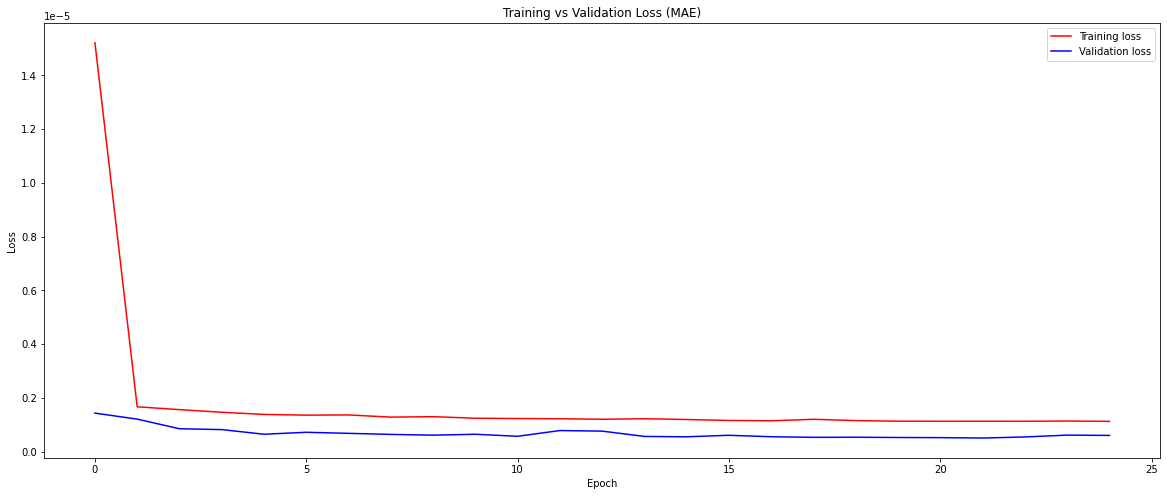

In [249]:
lag = 30
steps_ahead = 19
n_features = 15

train,val = df[1:7500], df[7500:]

path1="best_weights1.hdf5"

model1=model1(lag, steps_ahead, n_features)

training(lag,steps_ahead,n_features,model1,path1,train,val)

In [250]:
model1.load_weights(path1)
X_input=df[-(lag):].values
X_input=X_input.reshape(1,lag,n_features)
fina_pred=model1.predict(X_input)

In [251]:
fina_pred=fina_pred.reshape(fina_pred.shape[1],fina_pred.shape[2])
c1=['1M_pred', '2M_pred', '3M_pred', '6M_pred', '9M_pred', '1Y_pred',
       '2Y_pred', '3Y_pred', '4Y_pred', '5Y_pred', '6Y_pred', '7Y_pred',
       '8Y_pred', '9Y_pred', '10Y_pred']
fina_pred = pd.DataFrame(fina_pred)
fina_pred.columns=c1

In [252]:
fina_pred.index=pd.date_range(start="2021-03-01",end="2021-03-19")
#fina_pred

In [253]:
series_1m= df["1M"]
ser = go.Scatter(x=fina_pred.columns,
                         y=fina_pred[-1:].values[0])
layout = go.Layout(title='Forecast for 19th March', xaxis=dict(title='Maturities'),
                   yaxis=dict(title='(swap rates)'))

fig = go.Figure(data=[ser], layout=layout)
py.iplot(fig, sharing='public')

In [254]:
fina_pred[-1:]

1M_pred   2M_pred   3M_pred   6M_pred   9M_pred   1Y_pred  \
2021-03-19  0.003727  0.004368  0.004726  0.005018  0.005708  0.005515   

             2Y_pred   3Y_pred   4Y_pred   5Y_pred  6Y_pred   7Y_pred  \
2021-03-19  0.007337  0.009367  0.011061  0.012575  0.01414  0.015209   

            8Y_pred   9Y_pred  10Y_pred  
2021-03-19  0.01676  0.017677  0.019265

# Inferences:
## Statistical vs Encoder-Decoder Approach

### Comparing the errors: 

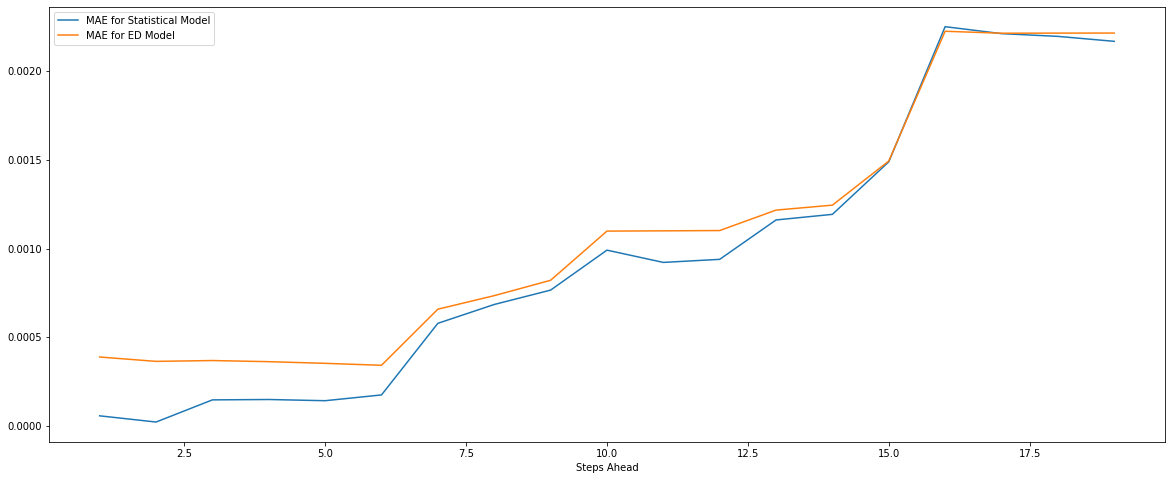

In [230]:
mae_stat=[5.662635839578442e-05,2.166635002200853e-05,0.00014659012092001583,0.0001486634612196854, 0.0001419201214213561,
 0.0001744392649622803,0.0005782504564898105,0.0006844137135564018, 0.0007654192487177609,0.0009908055646503887,
 0.000921630234624162,0.0009388956767221569, 0.0011609813897656826,0.0011926239413951134,
 0.0014887728956024327,0.0022506899294570267, 0.0022115187837263867,0.002196063143475188,0.002168125860126351]
plt.plot(np.arange(1,20),mae_stat,label="MAE for Statistical Model")
plt.plot(np.arange(1,20),mae,label="MAE for ED Model")
plt.xlabel("Steps Ahead")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [232]:
print("The MAE obtained using Encoder-Decoder is",np.asarray(mae).mean())
print("The MAE obtained using Statistical Modelling is ",np.asarray(mae_stat).mean())
print("Statistical Modelling performed ", 
      np.abs(np.asarray(mae).mean()-np.asarray(mae_stat).mean())/np.asarray(mae).mean()*100,
      "% better than the Encoder decoder method")

The MAE obtained using Encoder-Decoder is 0.001079501590155529
The MAE obtained using Statistical Modelling is  0.000959899816592105
Statistical Modelling performed  11.079351309356786 % better than the Encoder decoder method


In [234]:
'''   
    R21,MAE1=[],[]
    for index,i in enumerate(train.columns):
        print(i)
        r21=r22=0
        mae1=mae2=0
        for j in range(1,steps_ahead+1):
            r21=r21+r2_score(y_test[:,j-1,index],prediction[:,j-1,index])
            mae1=mae1+mean_absolute_error(y_test[:,j-1,index],prediction[:,j-1,index])
        print("Model1: R2",r21/steps_ahead,"MAE: ",mae1/steps_ahead)
        R21.append(r21/steps_ahead)
        MAE1.append(mae1/steps_ahead)

    plt.plot(train.columns,R21,label="r2 Model1")
    plt.legend()
    plt.title("R2")
    plt.show()

    plt.plot(train.columns,MAE1,label="mae Model1")
    plt.legend()
    plt.title("MAE")
    plt.show()
    
    R21,MAE1=[],[]
    for index,i in enumerate(train.columns):
        r21,mae1=[],[]
        for j in range(1,steps_ahead+1):
            r21.append(r2_score(y_test[:,j-1,index],prediction[:,j-1,index]))
            mae1.append(mean_absolute_error(y_test[:,j-1,index],prediction[:,j-1,index]))
        R21.append(r21)
        MAE1.append(mae1)

    plt.plot(np.arange(1,steps_ahead+1),np.asarray(R21).mean(axis=0),label="r2 Model1")
    plt.legend()
    plt.title("R2")
    plt.show()

    plt.plot(np.arange(1,steps_ahead+1),np.asarray(MAE1).mean(axis=0),label="mae Model1")
    plt.legend()
    plt.title("MAE")
    plt.show()
    
    for index,i in enumerate(train.columns):
      print(i,"**************************************************************************** \n \n")
      for j in range(steps_ahead-1,steps_ahead+1):
            plt.plot(y_test[:,j-1,index])
            plt.plot(prediction[:,j-1,index])
            plt.show()
    t1=model1.predict(test_input)
    t1=t1.reshape(steps_ahead,n_features)
    plt.plot(t1[-1:,:][0],label="Model1 Prediction")
    plt.show()
    return prediction,t1,MAE1,R21
'''     

'   \n    R21,MAE1=[],[]\n    for index,i in enumerate(train.columns):\n        print(i)\n        r21=r22=0\n        mae1=mae2=0\n        for j in range(1,steps_ahead+1):\n            r21=r21+r2_score(y_test[:,j-1,index],prediction[:,j-1,index])\n            mae1=mae1+mean_absolute_error(y_test[:,j-1,index],prediction[:,j-1,index])\n        print("Model1: R2",r21/steps_ahead,"MAE: ",mae1/steps_ahead)\n        R21.append(r21/steps_ahead)\n        MAE1.append(mae1/steps_ahead)\n\n    plt.plot(train.columns,R21,label="r2 Model1")\n    plt.legend()\n    plt.title("R2")\n    plt.show()\n\n    plt.plot(train.columns,MAE1,label="mae Model1")\n    plt.legend()\n    plt.title("MAE")\n    plt.show()\n    \n    R21,MAE1=[],[]\n    for index,i in enumerate(train.columns):\n        r21,mae1=[],[]\n        for j in range(1,steps_ahead+1):\n            r21.append(r2_score(y_test[:,j-1,index],prediction[:,j-1,index]))\n            mae1.append(mean_absolute_error(y_test[:,j-1,index],prediction[:,j-1,in

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
lstm_44 (LSTM)                  [(None, 150), (None, 99600       input_17[0][0]                   
__________________________________________________________________________________________________
repeat_vector_16 (RepeatVector) (None, 20, 150)      0           lstm_44[0][0]                    
__________________________________________________________________________________________________
lstm_45 (LSTM)                  (None, 20, 150)      180600      repeat_vector_16[0][0]           
                                                                 lstm_44[0][1]             

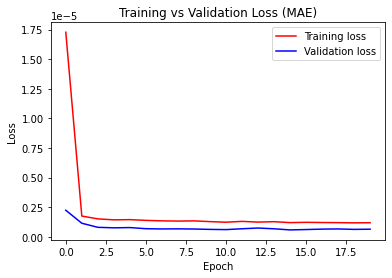

1M
Model1: R2 0.9796264263597803 MAE:  0.00048723112669867816
2M
Model1: R2 0.9782626045410451 MAE:  0.0005020720346649452
3M
Model1: R2 0.9620776565383485 MAE:  0.0009296293697891662
6M
Model1: R2 0.9837406821020418 MAE:  0.00046679301394249317
9M
Model1: R2 0.9721712299053541 MAE:  0.0008143777579829731
1Y
Model1: R2 0.9807903537504299 MAE:  0.0006198353814963923
2Y
Model1: R2 0.976984719742514 MAE:  0.000665156151273031
3Y
Model1: R2 0.975274180801516 MAE:  0.0007276891704326709
4Y
Model1: R2 0.9686035277350482 MAE:  0.0008419043882172126
5Y
Model1: R2 0.9665948996172797 MAE:  0.0008612740562812477
6Y
Model1: R2 0.9678175986104331 MAE:  0.0008044110041813829
7Y
Model1: R2 0.9641599329568844 MAE:  0.0008307963724475253
8Y
Model1: R2 0.9597908648699303 MAE:  0.0008683165586491554
9Y
Model1: R2 0.9443117559079784 MAE:  0.0010557304236492027
10Y
Model1: R2 0.9355391061376457 MAE:  0.0011135320672935455


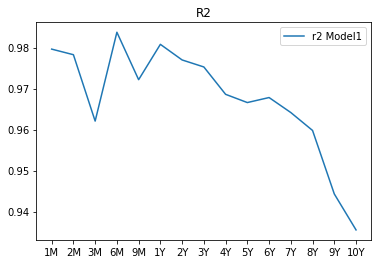

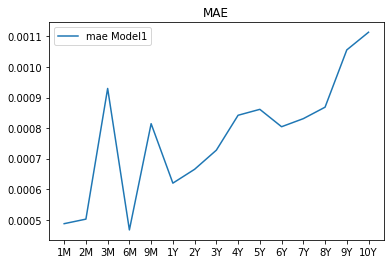

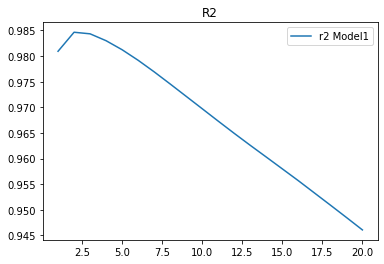

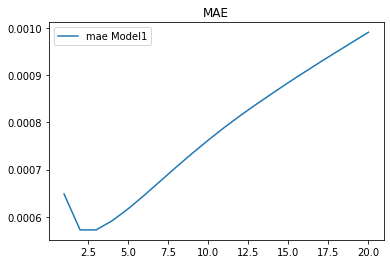

1M **************************************************************************** 
 



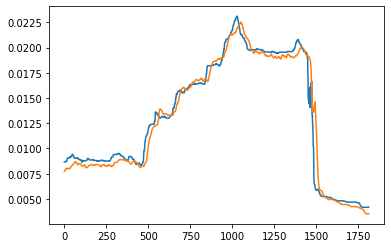

2M **************************************************************************** 
 



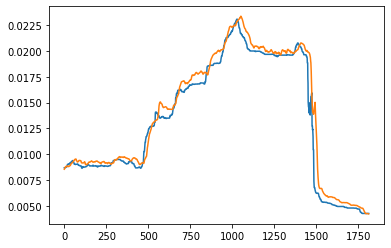

3M **************************************************************************** 
 



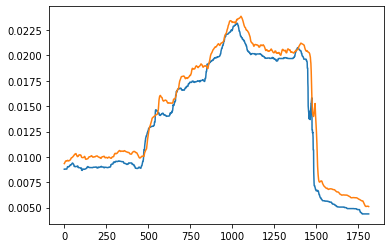

6M **************************************************************************** 
 



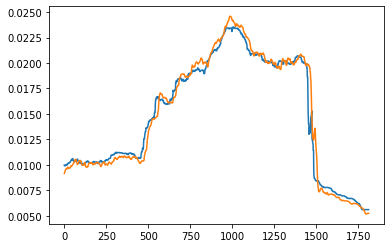

9M **************************************************************************** 
 



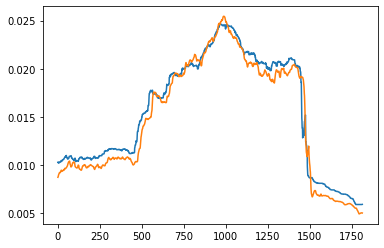

1Y **************************************************************************** 
 



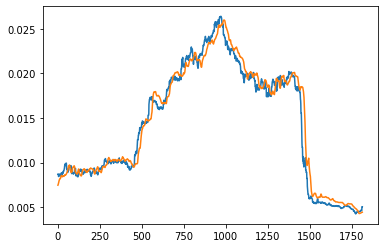

2Y **************************************************************************** 
 



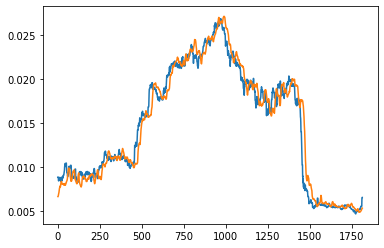

3Y **************************************************************************** 
 



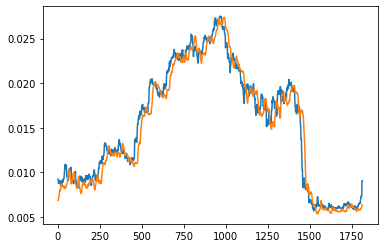

4Y **************************************************************************** 
 



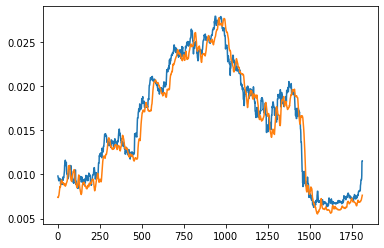

5Y **************************************************************************** 
 



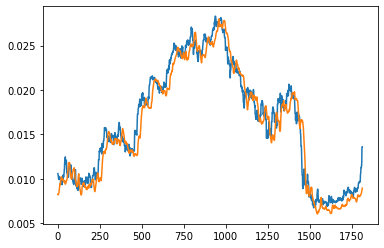

6Y **************************************************************************** 
 



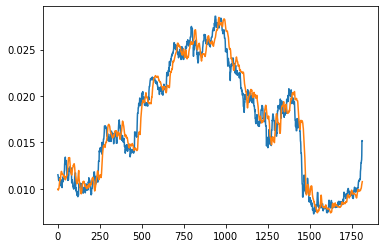

7Y **************************************************************************** 
 



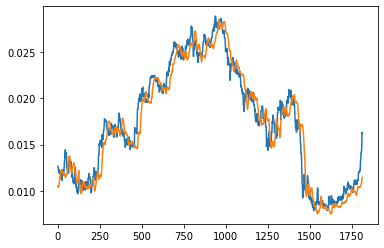

8Y **************************************************************************** 
 



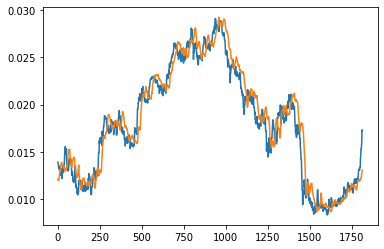

9Y **************************************************************************** 
 



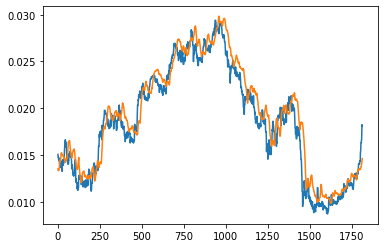

10Y **************************************************************************** 
 



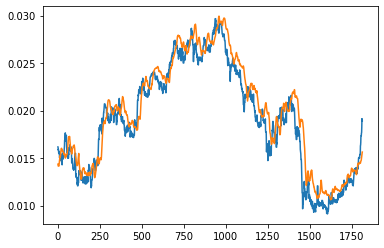

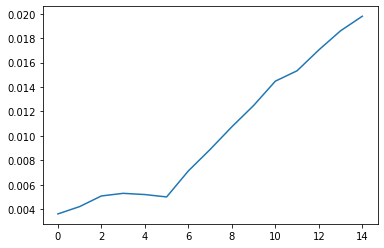

In [49]:
lag = 30
steps_ahead = 20 
n_features = 15

train,test = df[1:7500], df[7500:]
test_input=df[-lag:]
test_input=test_input.values.reshape(1,lag,n_features)

path1="best_weights1.hdf5"
path2="best_weights2.hdf5"

model1=model1(lag, steps_ahead, n_features)
#model2=model2(lag, steps_ahead, n_features)

prediction,t1,MAE1,R21=train_and_test(lag,steps_ahead,n_features,model1,path1,train,test,test_input)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 60, 15)]     0                                            
__________________________________________________________________________________________________
lstm_46 (LSTM)                  [(None, 150), (None, 99600       input_18[0][0]                   
__________________________________________________________________________________________________
repeat_vector_17 (RepeatVector) (None, 20, 150)      0           lstm_46[0][0]                    
__________________________________________________________________________________________________
lstm_47 (LSTM)                  (None, 20, 150)      180600      repeat_vector_17[0][0]           
                                                                 lstm_46[0][1]             

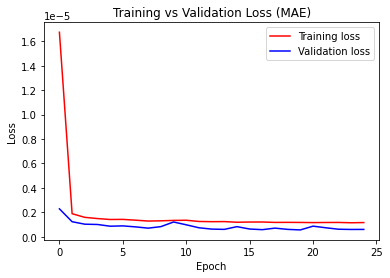

1M
Model1: R2 0.976113537100027 MAE:  0.00048389473401719144
2M
Model1: R2 0.9791811976951642 MAE:  0.000471028023687102
3M
Model1: R2 0.9755159150667223 MAE:  0.000630172696425136
6M
Model1: R2 0.9841991753671385 MAE:  0.00042220188213127653
9M
Model1: R2 0.9844104050286793 MAE:  0.000499024482702288
1Y
Model1: R2 0.970524775659252 MAE:  0.0008618979169098432
2Y
Model1: R2 0.976149332293376 MAE:  0.0006690617880320481
3Y
Model1: R2 0.9741449214341122 MAE:  0.0007561304442314742
4Y
Model1: R2 0.9670418766825147 MAE:  0.0008883512253454179
5Y
Model1: R2 0.9620694347462194 MAE:  0.0009434639032232124
6Y
Model1: R2 0.9648867998781316 MAE:  0.0008458780954679855
7Y
Model1: R2 0.9584305463602716 MAE:  0.000929299296481499
8Y
Model1: R2 0.9608101857702275 MAE:  0.0008382136529292424
9Y
Model1: R2 0.9567691570834244 MAE:  0.0008791655569563881
10Y
Model1: R2 0.951738243995235 MAE:  0.0009224923457852791


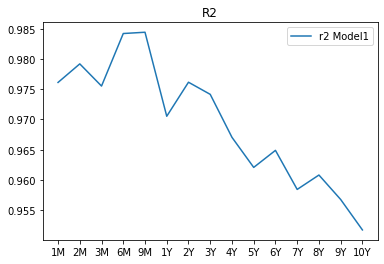

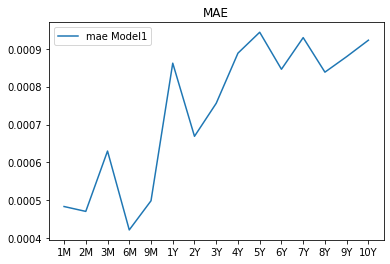

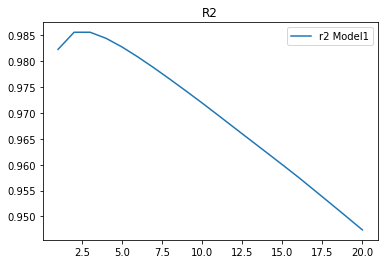

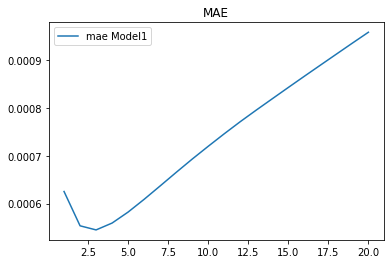

1M **************************************************************************** 
 



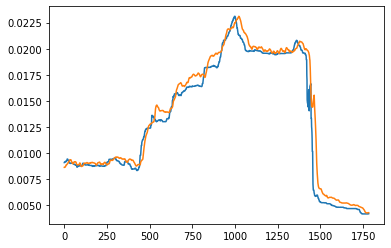

2M **************************************************************************** 
 



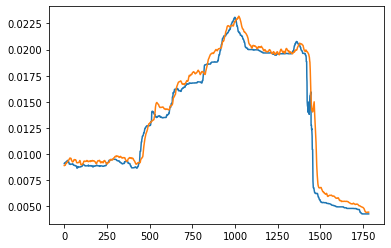

3M **************************************************************************** 
 



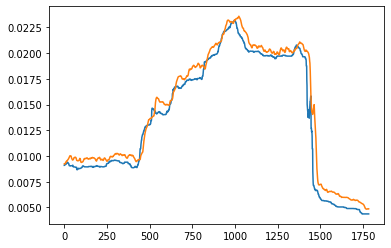

6M **************************************************************************** 
 



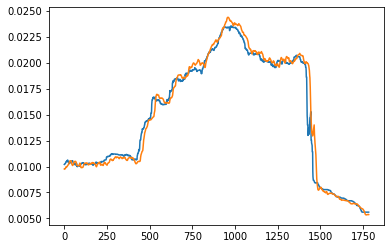

9M **************************************************************************** 
 



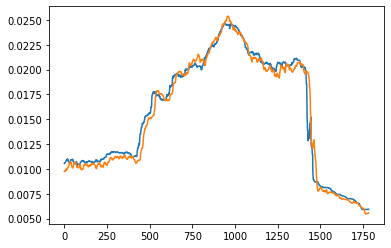

1Y **************************************************************************** 
 



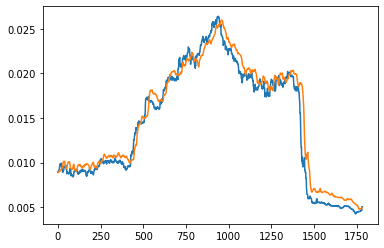

2Y **************************************************************************** 
 



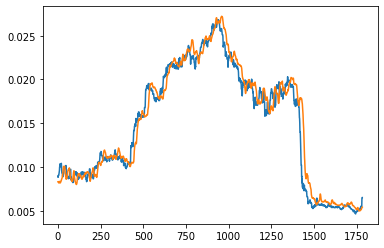

3Y **************************************************************************** 
 



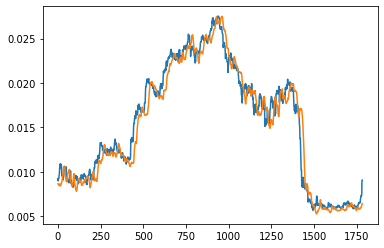

4Y **************************************************************************** 
 



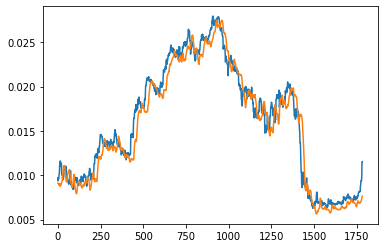

5Y **************************************************************************** 
 



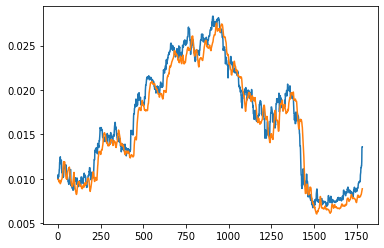

6Y **************************************************************************** 
 



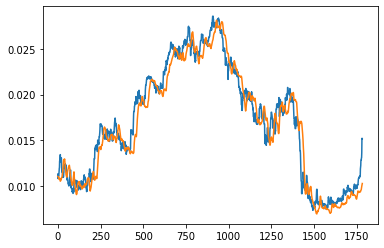

7Y **************************************************************************** 
 



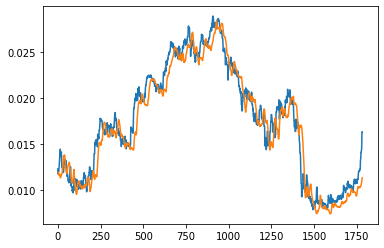

8Y **************************************************************************** 
 



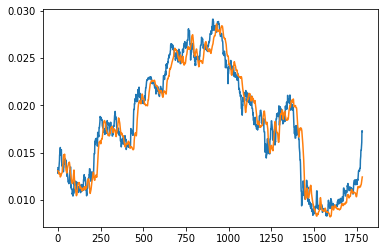

9Y **************************************************************************** 
 



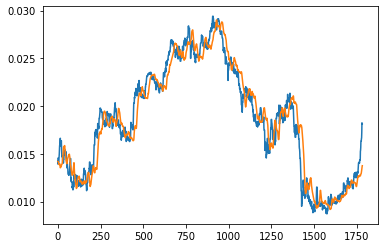

10Y **************************************************************************** 
 



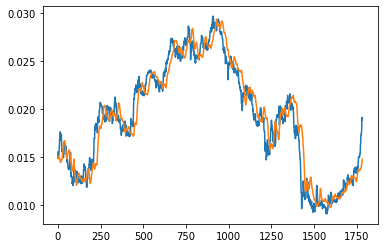

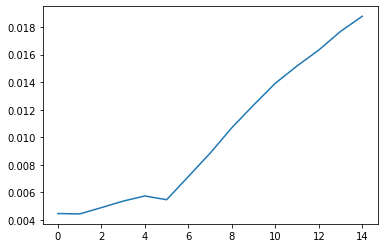

In [53]:
lag = 60
steps_ahead = 20 
n_features = 15

train,test = df[1:7500], df[7500:]
test_input=df[-lag:]
test_input=test_input.values.reshape(1,lag,n_features)

path1="best_weights1.hdf5"
path2="best_weights2.hdf5"

model1=model1(lag, steps_ahead, n_features)
#model2=model2(lag, steps_ahead, n_features)

prediction,t1,MAE1,R21=train_and_test(lag,steps_ahead,n_features,model1,path1,train,test,test_input)

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 10, 15)]     0                                            
__________________________________________________________________________________________________
lstm_48 (LSTM)                  [(None, 150), (None, 99600       input_19[0][0]                   
__________________________________________________________________________________________________
repeat_vector_18 (RepeatVector) (None, 20, 150)      0           lstm_48[0][0]                    
__________________________________________________________________________________________________
lstm_49 (LSTM)                  (None, 20, 150)      180600      repeat_vector_18[0][0]           
                                                                 lstm_48[0][1]             

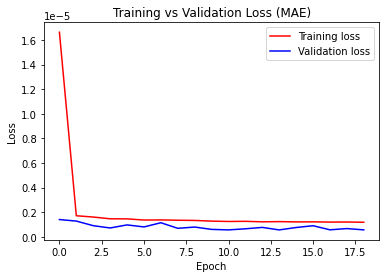

1M
Model1: R2 0.9757253600675874 MAE:  0.000535224222630681
2M
Model1: R2 0.9780011068006692 MAE:  0.0005286494967731267
3M
Model1: R2 0.9729147717006923 MAE:  0.0007356355749040564
6M
Model1: R2 0.9843346615955193 MAE:  0.0004209683211726516
9M
Model1: R2 0.9833202585984564 MAE:  0.0005249127904433033
1Y
Model1: R2 0.9748788526959992 MAE:  0.0007454203113954208
2Y
Model1: R2 0.9743572940538753 MAE:  0.0007351869543122333
3Y
Model1: R2 0.9712252351223108 MAE:  0.0008220380822034844
4Y
Model1: R2 0.9676607170263842 MAE:  0.0008710205074978631
5Y
Model1: R2 0.9655162107948267 MAE:  0.0008808730309112554
6Y
Model1: R2 0.9655511485132603 MAE:  0.0008285484637925982
7Y
Model1: R2 0.9658557706923216 MAE:  0.0007979075717416374
8Y
Model1: R2 0.9618810959916152 MAE:  0.0008418419822240119
9Y
Model1: R2 0.9556861054075053 MAE:  0.0008963074304898369
10Y
Model1: R2 0.9378443558077318 MAE:  0.0010811374838596483


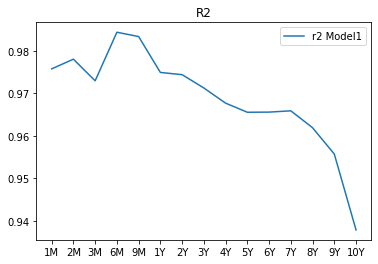

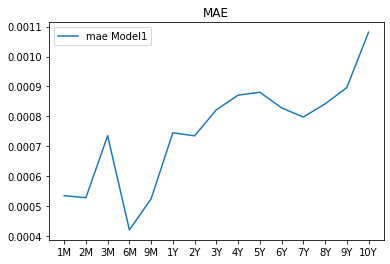

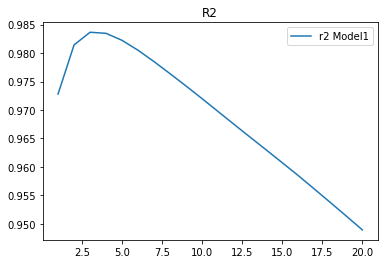

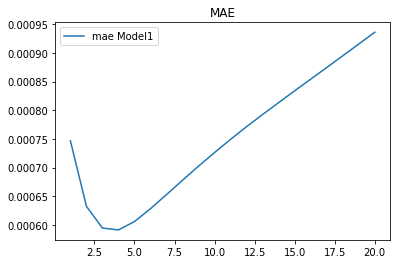

1M **************************************************************************** 
 



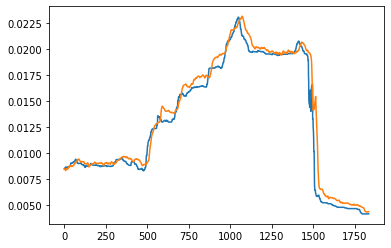

2M **************************************************************************** 
 



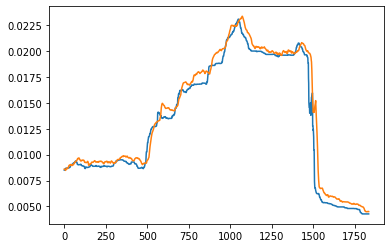

3M **************************************************************************** 
 



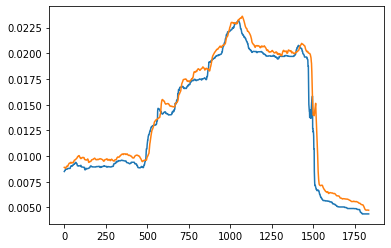

6M **************************************************************************** 
 



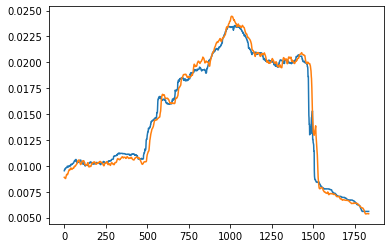

9M **************************************************************************** 
 



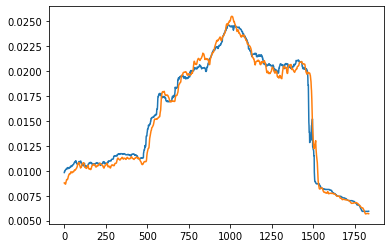

1Y **************************************************************************** 
 



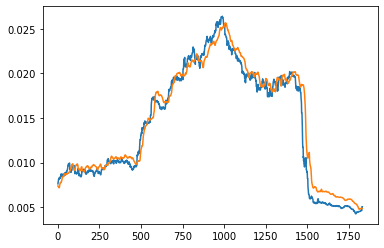

2Y **************************************************************************** 
 



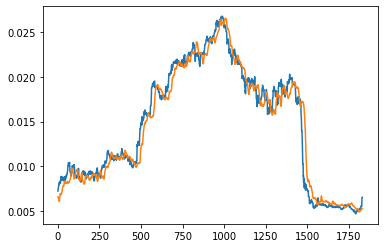

3Y **************************************************************************** 
 



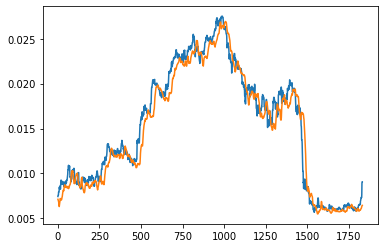

4Y **************************************************************************** 
 



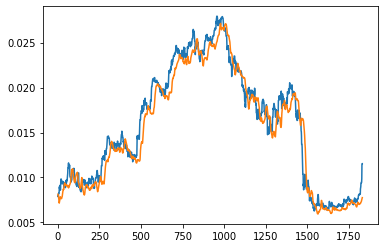

5Y **************************************************************************** 
 



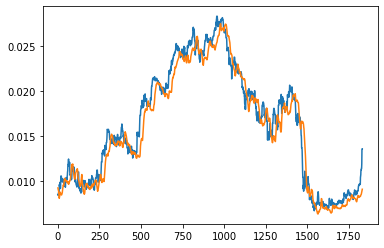

6Y **************************************************************************** 
 



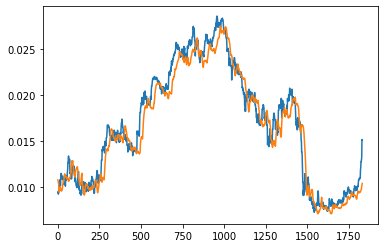

7Y **************************************************************************** 
 



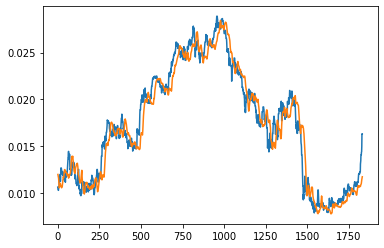

8Y **************************************************************************** 
 



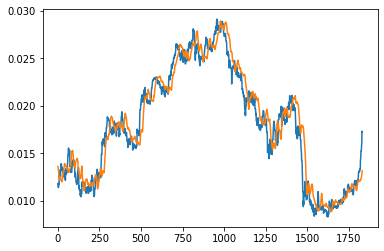

9Y **************************************************************************** 
 



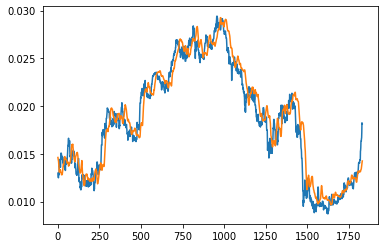

10Y **************************************************************************** 
 



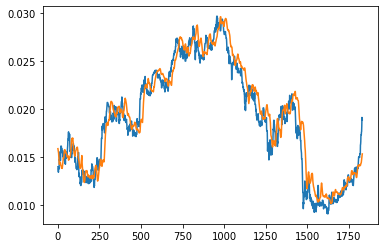

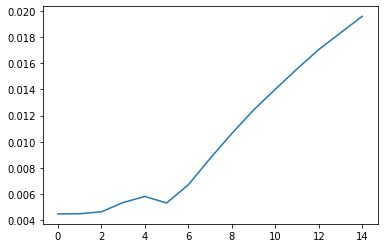

In [57]:
lag = 10
steps_ahead = 20 
n_features = 15

train,test = df[1:7500], df[7500:]
test_input=df[-lag:]
test_input=test_input.values.reshape(1,lag,n_features)

path1="best_weights1.hdf5"
path2="best_weights2.hdf5"

model1=model1(lag, steps_ahead, n_features)
#model2=model2(lag, steps_ahead, n_features)

prediction,t1,MAE1,R21=train_and_test(lag,steps_ahead,n_features,model1,path1,train,test,test_input)

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 20, 15)]     0                                            
__________________________________________________________________________________________________
lstm_50 (LSTM)                  [(None, 150), (None, 99600       input_20[0][0]                   
__________________________________________________________________________________________________
repeat_vector_19 (RepeatVector) (None, 20, 150)      0           lstm_50[0][0]                    
__________________________________________________________________________________________________
lstm_51 (LSTM)                  (None, 20, 150)      180600      repeat_vector_19[0][0]           
                                                                 lstm_50[0][1]             

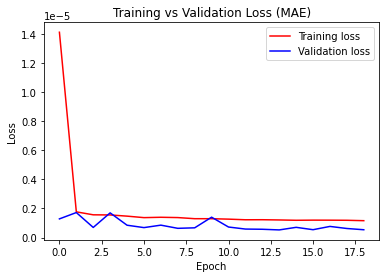

1M
Model1: R2 0.9794732350573996 MAE:  0.000516049939402907
2M
Model1: R2 0.9840694705136552 MAE:  0.00035379290537067775
3M
Model1: R2 0.97865315717679 MAE:  0.000567112295343634
6M
Model1: R2 0.9847735366743114 MAE:  0.0004223468221276999
9M
Model1: R2 0.9834693248960917 MAE:  0.0004969635527588701
1Y
Model1: R2 0.9652822115584495 MAE:  0.0009583986550926627
2Y
Model1: R2 0.976410589947383 MAE:  0.0006782415429448936
3Y
Model1: R2 0.9772569775720659 MAE:  0.0006636025031169507
4Y
Model1: R2 0.9729972400605039 MAE:  0.0007521900471870527
5Y
Model1: R2 0.9687905646874482 MAE:  0.0008080255387040141
6Y
Model1: R2 0.9673528268708536 MAE:  0.0008111051863890854
7Y
Model1: R2 0.9615381538713237 MAE:  0.0008713749034647119
8Y
Model1: R2 0.9612595673070757 MAE:  0.0008351761994031318
9Y
Model1: R2 0.9575121653607923 MAE:  0.0008596486529618237
10Y
Model1: R2 0.94689841109351 MAE:  0.0009792878228168443


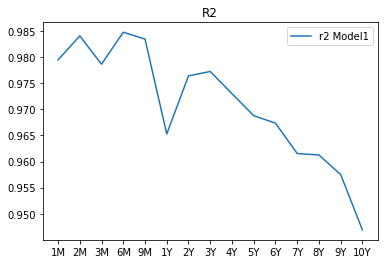

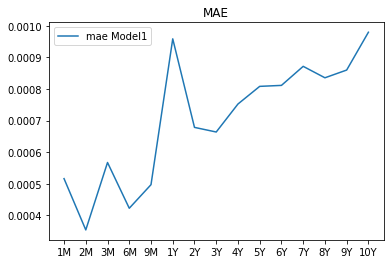

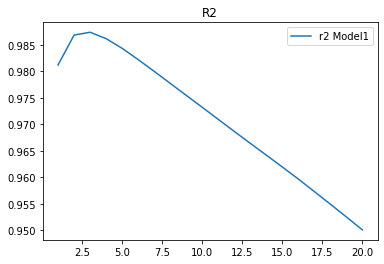

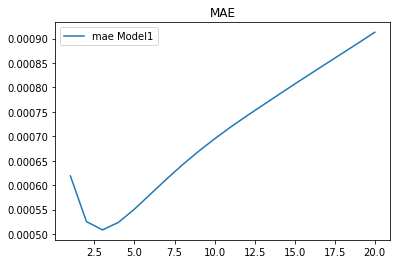

1M **************************************************************************** 
 



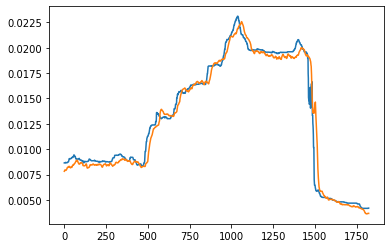

2M **************************************************************************** 
 



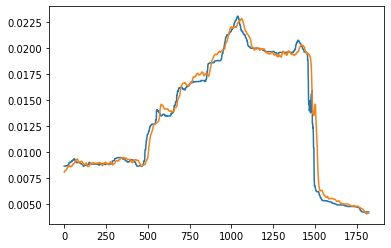

3M **************************************************************************** 
 



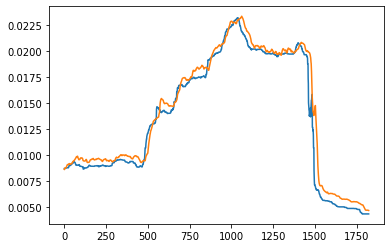

6M **************************************************************************** 
 



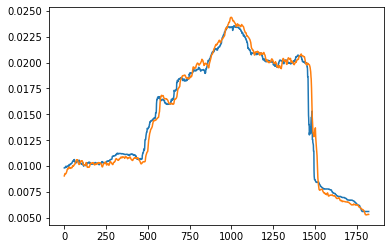

9M **************************************************************************** 
 



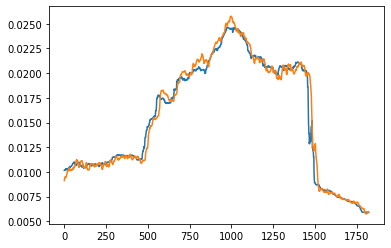

1Y **************************************************************************** 
 



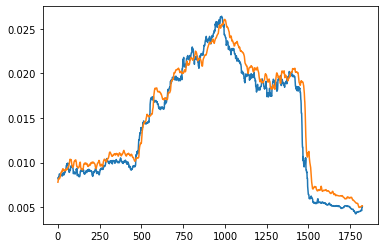

2Y **************************************************************************** 
 



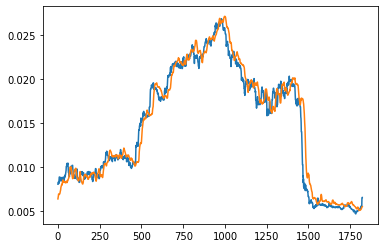

3Y **************************************************************************** 
 



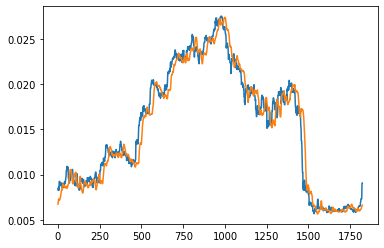

4Y **************************************************************************** 
 



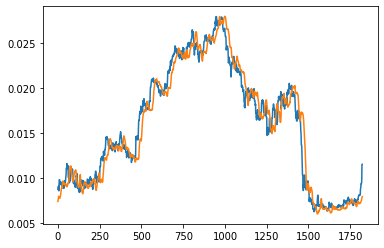

5Y **************************************************************************** 
 



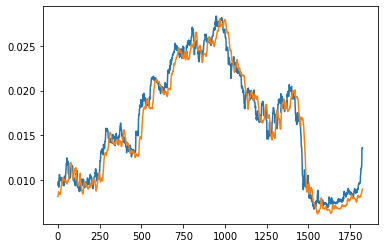

6Y **************************************************************************** 
 



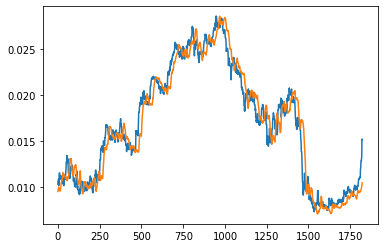

7Y **************************************************************************** 
 



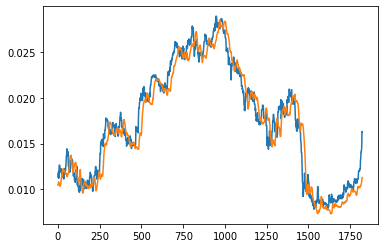

8Y **************************************************************************** 
 



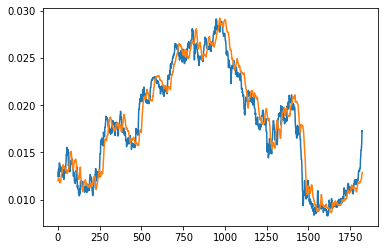

9Y **************************************************************************** 
 



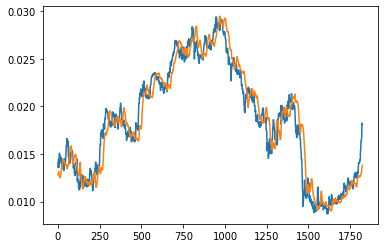

10Y **************************************************************************** 
 



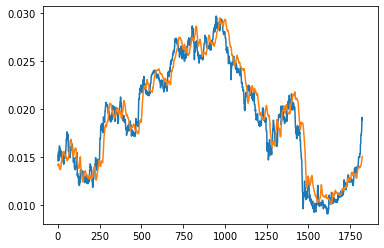

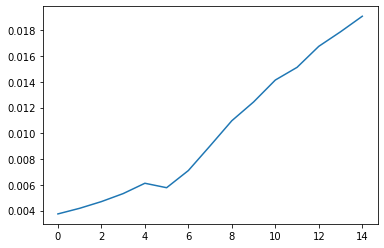

In [60]:
lag = 20
steps_ahead = 20 
n_features = 15

train,test = df[1:7500], df[7500:]
test_input=df[-lag:]
test_input=test_input.values.reshape(1,lag,n_features)

path1="best_weights1.hdf5"
path2="best_weights2.hdf5"

model1=model1(lag, steps_ahead, n_features)
#model2=model2(lag, steps_ahead, n_features)

prediction,t1,MAE1,R21=train_and_test(lag,steps_ahead,n_features,model1,path1,train,test,test_input)

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 20, 15)]     0                                            
__________________________________________________________________________________________________
lstm_62 (LSTM)                  [(None, 150), (None, 99600       input_26[0][0]                   
__________________________________________________________________________________________________
repeat_vector_25 (RepeatVector) (None, 19, 150)      0           lstm_62[0][0]                    
__________________________________________________________________________________________________
lstm_63 (LSTM)                  (None, 19, 150)      180600      repeat_vector_25[0][0]           
                                                                 lstm_62[0][1]             

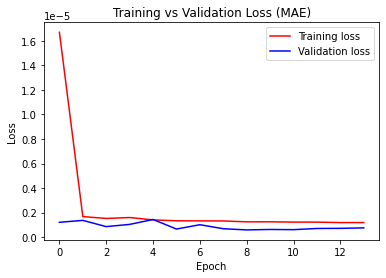

1M
Model1: R2 0.9805327241795847 MAE:  0.0004158204100242732
2M
Model1: R2 0.9798348576433575 MAE:  0.00047214295454774775
3M
Model1: R2 0.9652066132546312 MAE:  0.0008588561424716243
6M
Model1: R2 0.979144674017447 MAE:  0.0005651203857402602
9M
Model1: R2 0.9730933730228891 MAE:  0.0007712805690108269
1Y
Model1: R2 0.9738847977565408 MAE:  0.0007504846779865169
2Y
Model1: R2 0.9734551908067175 MAE:  0.0007703319979988294
3Y
Model1: R2 0.9667682388242079 MAE:  0.0009138751637618371
4Y
Model1: R2 0.9655981282609998 MAE:  0.0009057036959945119
5Y
Model1: R2 0.9586079557149617 MAE:  0.0009994533917692756
6Y
Model1: R2 0.9677166735291515 MAE:  0.0007997358837462436
7Y
Model1: R2 0.9669793642666631 MAE:  0.0007910542764584111
8Y
Model1: R2 0.961299477000312 MAE:  0.000851789026743793
9Y
Model1: R2 0.9486772298094245 MAE:  0.000999714537348674
10Y
Model1: R2 0.9465035945292591 MAE:  0.0009943517766746476


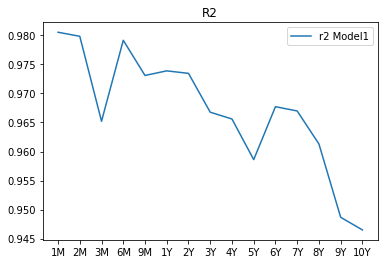

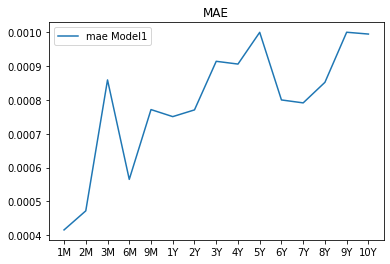

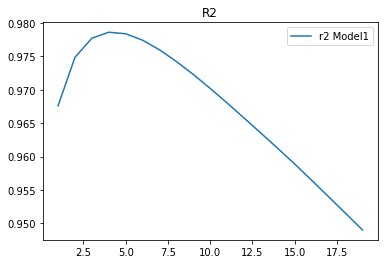

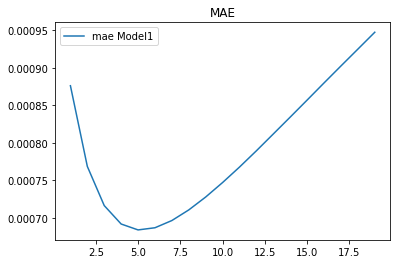

1M **************************************************************************** 
 



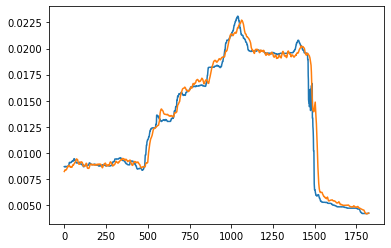

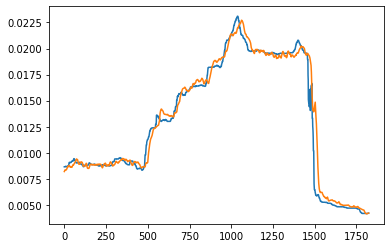

2M **************************************************************************** 
 



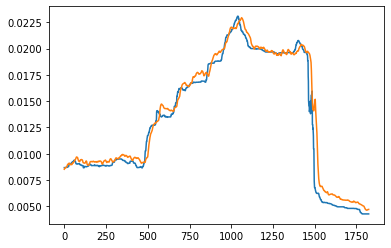

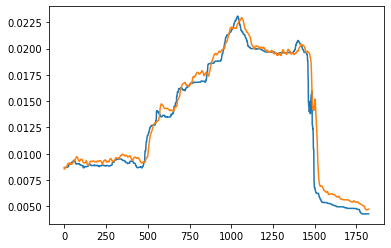

3M **************************************************************************** 
 



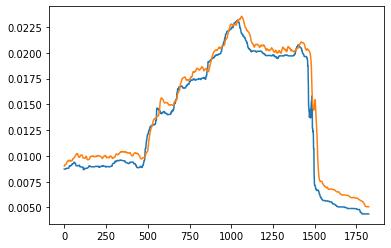

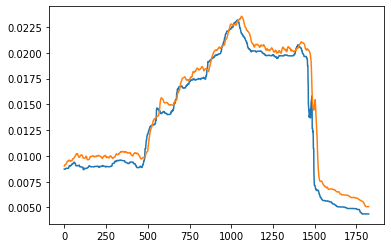

6M **************************************************************************** 
 



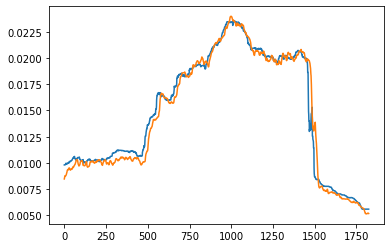

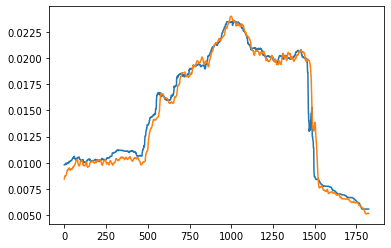

9M **************************************************************************** 
 



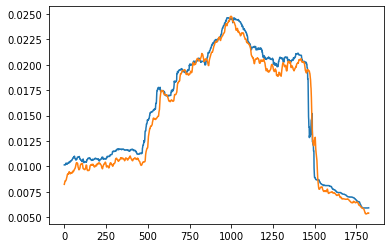

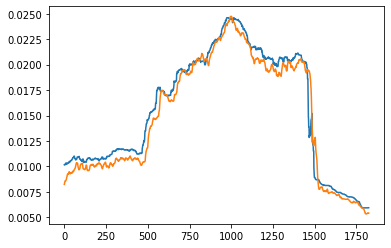

1Y **************************************************************************** 
 



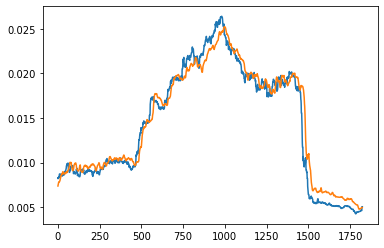

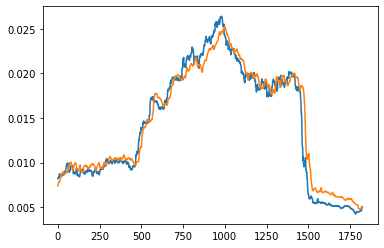

2Y **************************************************************************** 
 



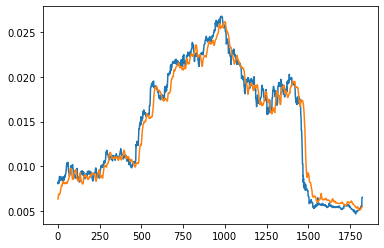

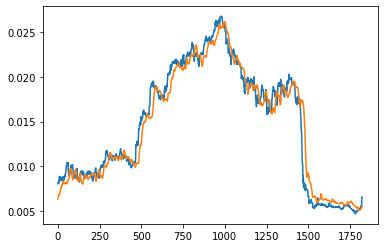

3Y **************************************************************************** 
 



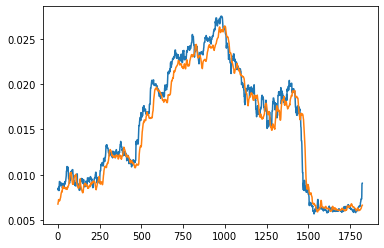

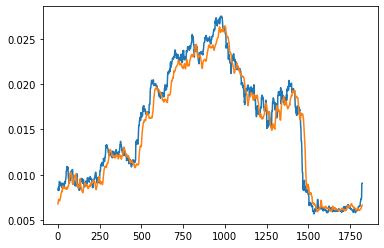

4Y **************************************************************************** 
 



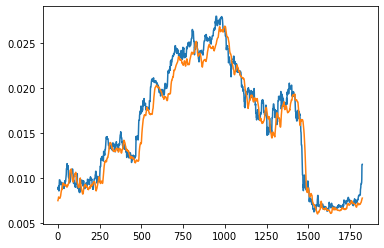

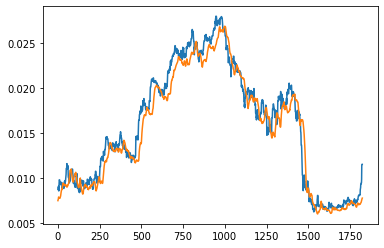

5Y **************************************************************************** 
 



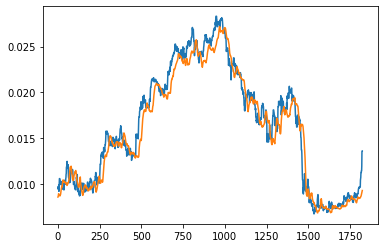

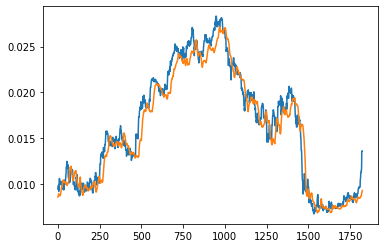

6Y **************************************************************************** 
 



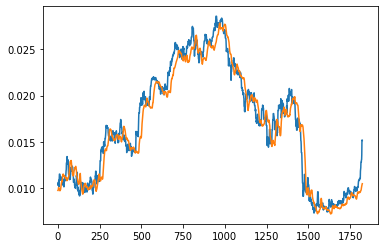

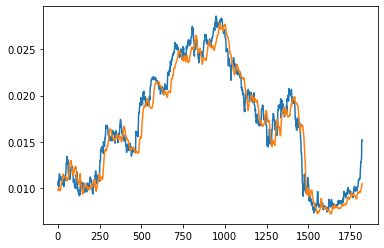

7Y **************************************************************************** 
 



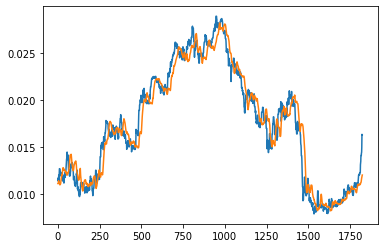

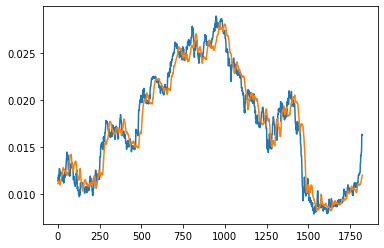

8Y **************************************************************************** 
 



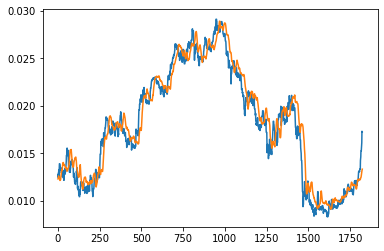

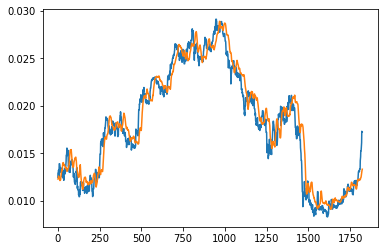

9Y **************************************************************************** 
 



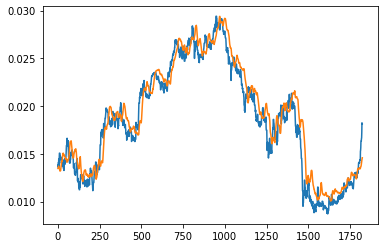

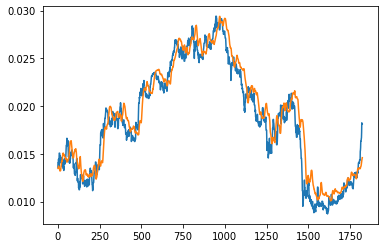

10Y **************************************************************************** 
 



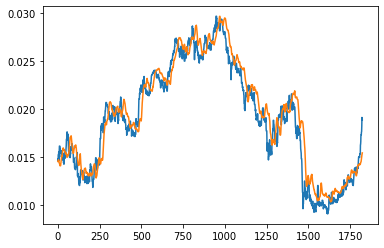

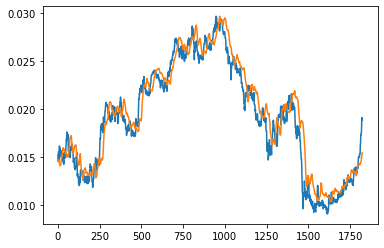

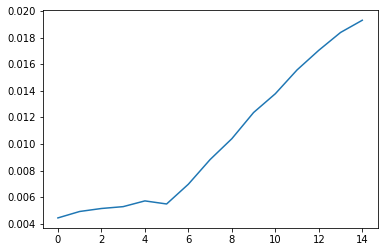

In [86]:
lag = 20
steps_ahead = 19
n_features = 15

train,test = df[1:7500], df[7500:]
test_input=df[-lag:]
test_input=test_input.values.reshape(1,lag,n_features)

path1="best_weights1.hdf5"
path2="best_weights2.hdf5"

model1=model1(lag, steps_ahead, n_features)
#model2=model2(lag, steps_ahead, n_features)

prediction,t1,MAE1,R21=train_and_test(lag,steps_ahead,n_features,model1,path1,train,test,test_input)

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 30, 15)]     0                                            
__________________________________________________________________________________________________
lstm_64 (LSTM)                  [(None, 150), (None, 99600       input_27[0][0]                   
__________________________________________________________________________________________________
repeat_vector_26 (RepeatVector) (None, 19, 150)      0           lstm_64[0][0]                    
__________________________________________________________________________________________________
lstm_65 (LSTM)                  (None, 19, 150)      180600      repeat_vector_26[0][0]           
                                                                 lstm_64[0][1]             

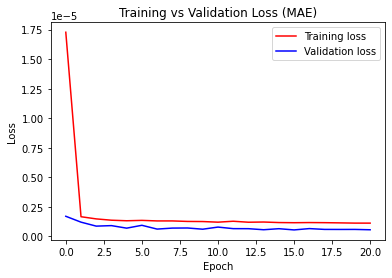

1M
Model1: R2 0.9802177914935554 MAE:  0.0004519946427951776
2M
Model1: R2 0.981929916971792 MAE:  0.00040939816498078234
3M
Model1: R2 0.9743303127814379 MAE:  0.0006711419905575456
6M
Model1: R2 0.9835393865506278 MAE:  0.0004242582321805175
9M
Model1: R2 0.985654367398644 MAE:  0.0004235484202254212
1Y
Model1: R2 0.9684078774008457 MAE:  0.0009175604461859988
2Y
Model1: R2 0.9782394925748129 MAE:  0.0006584353709634879
3Y
Model1: R2 0.9783849280041439 MAE:  0.000653243895405329
4Y
Model1: R2 0.9662261409583449 MAE:  0.0009202888625552079
5Y
Model1: R2 0.9549826349918605 MAE:  0.0010661502357626907
6Y
Model1: R2 0.9612023159040544 MAE:  0.0009238033844206538
7Y
Model1: R2 0.962388321693467 MAE:  0.0008670532792036072
8Y
Model1: R2 0.9641049434011614 MAE:  0.0008004290299897145
9Y
Model1: R2 0.9603946225061274 MAE:  0.0008440877696485804
10Y
Model1: R2 0.9526526425501369 MAE:  0.0009264554013701328


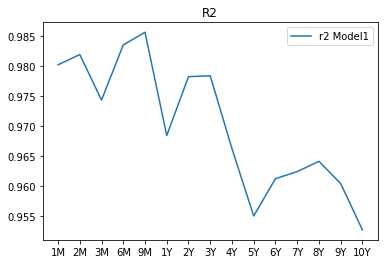

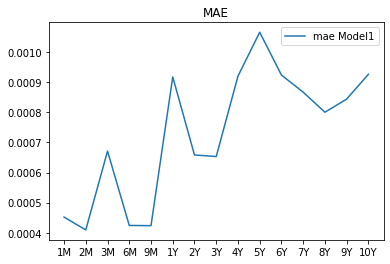

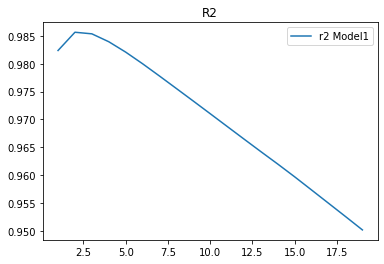

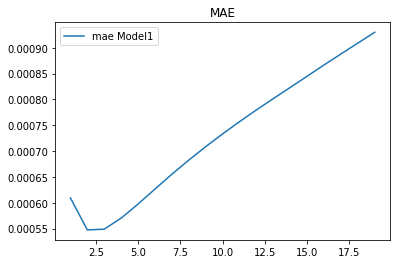

1M **************************************************************************** 
 



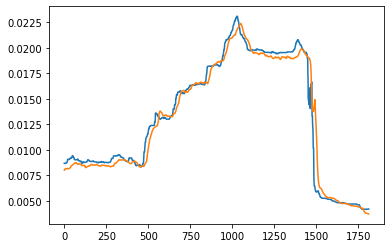

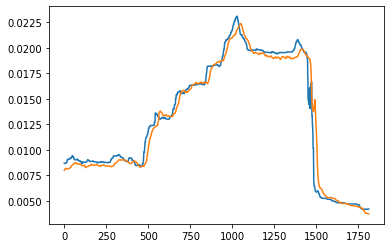

2M **************************************************************************** 
 



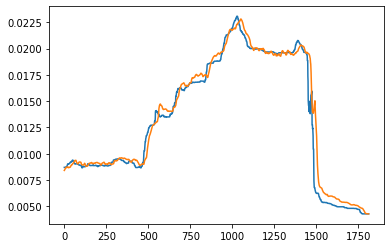

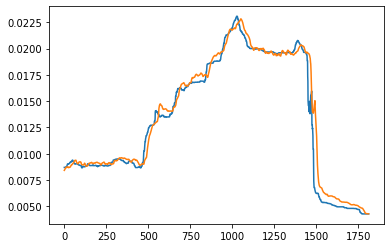

3M **************************************************************************** 
 



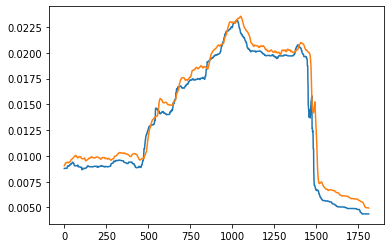

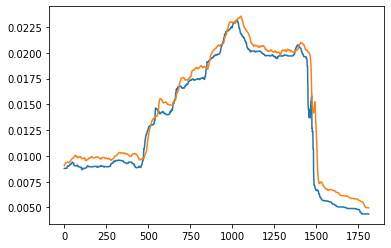

6M **************************************************************************** 
 



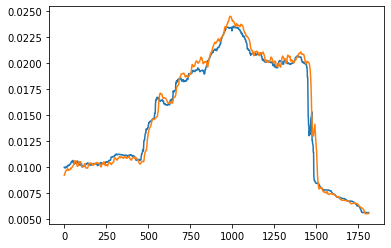

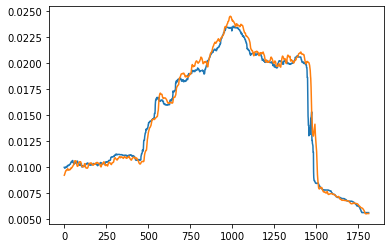

9M **************************************************************************** 
 



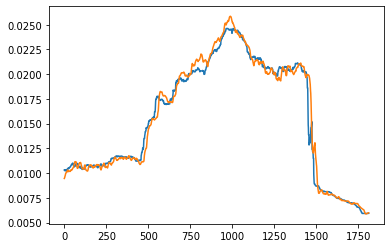

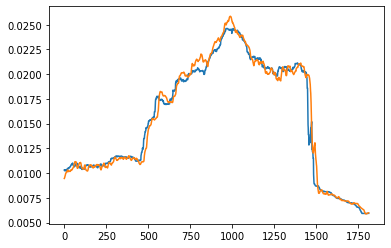

1Y **************************************************************************** 
 



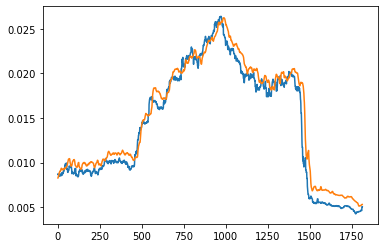

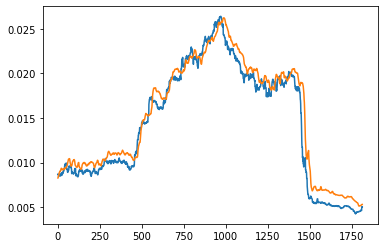

2Y **************************************************************************** 
 



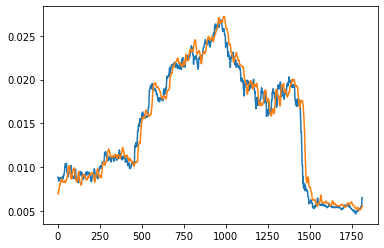

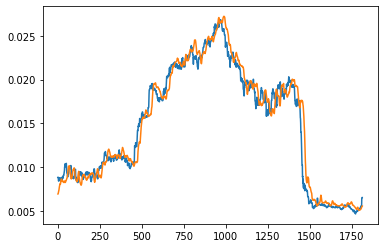

3Y **************************************************************************** 
 



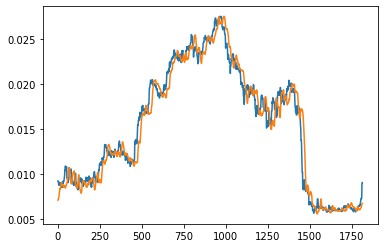

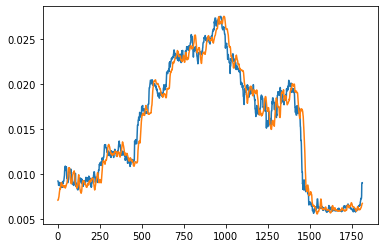

4Y **************************************************************************** 
 



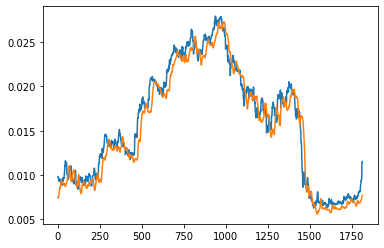

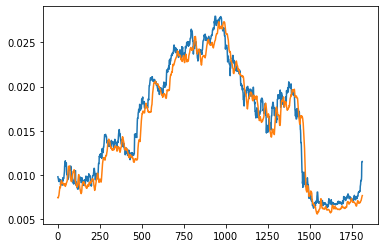

5Y **************************************************************************** 
 



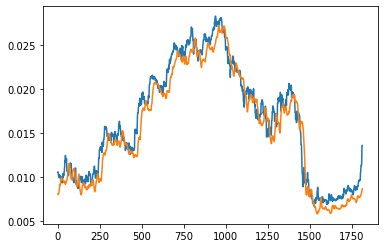

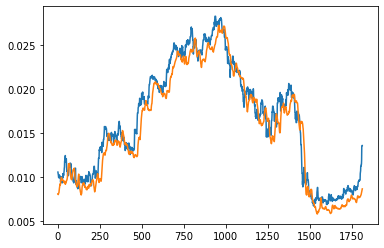

6Y **************************************************************************** 
 



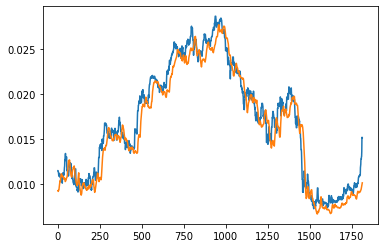

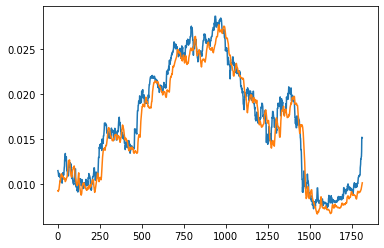

7Y **************************************************************************** 
 



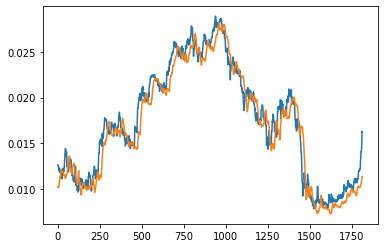

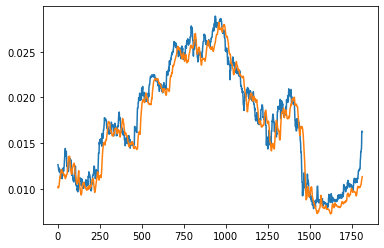

8Y **************************************************************************** 
 



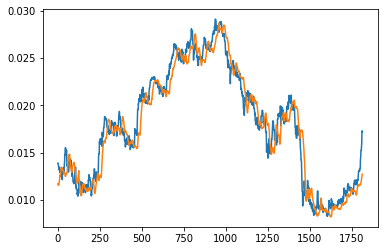

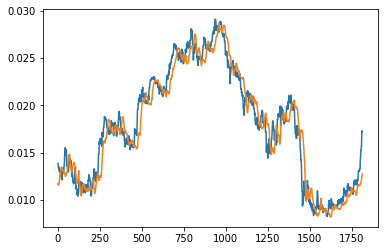

9Y **************************************************************************** 
 



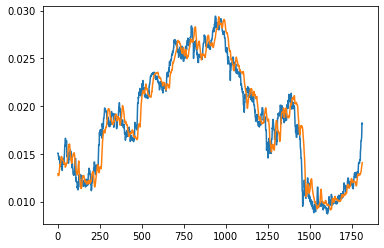

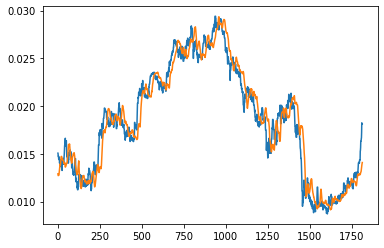

10Y **************************************************************************** 
 



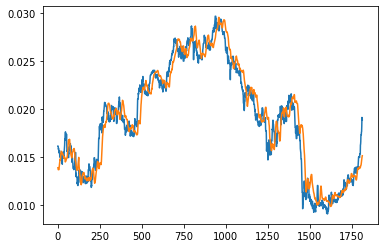

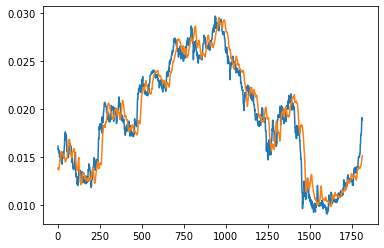

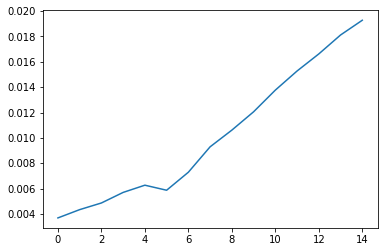

In [91]:
lag = 30
steps_ahead = 19
n_features = 15

train,test = df[1:7500], df[7500:]
test_input=df[-lag:]
test_input=test_input.values.reshape(1,lag,n_features)

path1="best_weights1.hdf5"
path2="best_weights2.hdf5"

model1=model1(lag, steps_ahead, n_features)
#model2=model2(lag, steps_ahead, n_features)

prediction,t1,MAE1,R21=train_and_test(lag,steps_ahead,n_features,model1,path1,train,test,test_input)

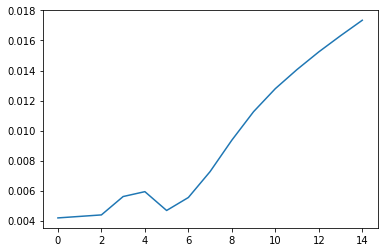

In [97]:
plt.plot(test_input.reshape(30,15)[-1:,:][0])

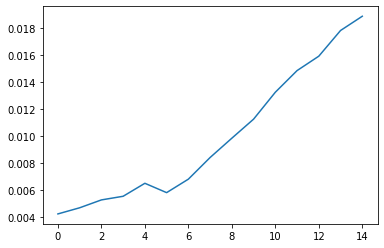

In [102]:
    plt.plot(t1[-20:,:][0],label="Model1 Prediction")
    plt.show()